# Readmition predictor project - EDA - Catboost by dekel
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

CatBoost (Categorical Boosting) is a gradient boosting algorithm that excels at handling datasets with a mix of categorical and numerical features.

### 1. **Native Handling of Categorical Features**

CatBoost's standout feature is its ability to natively handle categorical features without requiring extensive preprocessing, such as one-hot encoding or label encoding. This is achieved through:

- **Optimal Ordered Target Encoding**: CatBoost employs a sophisticated technique to encode categorical variables, which helps preserve the information and order within the data while avoiding overfitting. It iteratively updates the encoding based on the target value, ensuring that the encoding is robust and reduces information loss.

### 2. **Efficient Handling of High Cardinality**

CatBoost can efficiently handle high cardinality categorical features (features with a large number of unique categories). Traditional methods like one-hot encoding would result in a very high-dimensional feature space, which can be computationally expensive and prone to overfitting. CatBoost's encoding methods mitigate this issue by summarizing the information in a more compact form.

### 3. **Built-in Feature Importance and Selection**

CatBoost provides built-in mechanisms to compute feature importance, helping to identify the most relevant features in your dataset. This is particularly useful in datasets with mixed feature types, where understanding the importance of categorical features alongside numerical ones can be challenging.

### 4. **Robust to Noisy Data and Overfitting**

CatBoost includes several regularization techniques that make it robust to noisy data and reduce the risk of overfitting. The Ordered Boosting process helps in achieving this robustness by carefully handling the ordering of the data points, ensuring that the model is trained on unbiased data.

### 5. **Advanced Handling of Missing Values**

CatBoost can handle missing values natively without requiring imputation. It uses a technique that considers the missing values during the decision-making process, ensuring that the impact of missing data is minimized.

### 6. **Fast Training with GPU Support**

CatBoost supports GPU acceleration, which can significantly speed up the training process, especially on large datasets with mixed feature types. This makes it competitive in terms of training time compared to other gradient boosting algorithms like XGBoost and LightGBM.

### 7. **Strong Generalization Capabilities**

CatBoost generally shows strong performance in terms of generalization due to its advanced regularization techniques and the way it handles categorical variables. This often leads to better performance on unseen data compared to other algorithms that require manual handling of categorical features.

### 8. **Ease of Use and Integration**

The simplicity of using CatBoost is another advantage. The need for minimal data preprocessing steps makes it user-friendly. The library is well-documented and integrates seamlessly with common data science workflows in Python and R.

### Strengths Over Other Algorithms

- **XGBoost**: While XGBoost is highly efficient and has been a top choice for many Kaggle competitions, it requires extensive preprocessing of categorical features, which can be cumbersome and prone to introducing errors. CatBoost's native handling of these features simplifies the workflow and often results in better performance on categorical data.
  
- **LightGBM**: Similar to XGBoost, LightGBM also needs manual encoding of categorical features. Although it has mechanisms for handling large datasets efficiently, it may not perform as well as CatBoost in scenarios with many categorical features due to the additional preprocessing steps required.

- **Random Forests**: Random Forests can handle categorical features using label encoding, but they do not natively support ordered target encoding, leading to potential information loss and suboptimal performance compared to CatBoost. Additionally, Random Forests do not have the same level of built-in regularization, which can lead to overfitting on complex datasets.

### Conclusion

CatBoost is a powerful and versatile algorithm that excels in scenarios involving a mix of categorical and numerical features. Its native handling of categorical data, advanced regularization techniques, efficient training processes, and ease of use make it a strong candidate for many machine learning tasks. Its strengths over other algorithms, particularly in dealing with high-cardinality categorical features and preventing overfitting, make it a preferred choice for many data scientists and machine learning practitioners.

# 0. setup

In [2]:
# Basic imports
import os
import re
import glob
import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
from scipy.stats import skew


# Set IPython to print all variables in each cell
InteractiveShell.ast_node_interactivity = "all"

# Sklearn and other ML-related imports
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (PowerTransformer, QuantileTransformer, 
                                   RobustScaler, StandardScaler, OneHotEncoder, LabelEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from copy import deepcopy

#  imblearn sampeling features
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# CatBoost and Optuna imports
from catboost import CatBoostClassifier
import optuna
from optuna import Trial, create_study
from optuna.samplers import TPESampler
from optuna.distributions import CategoricalDistribution
# Custom data transformers 
import data_transformers as dt

# Path settings 
from paths import DATA_PATH

# To handle warnings related to certain libraries (e.g., Sklearn)
import warnings
warnings.filterwarnings("ignore")



# import for balancer
from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, ClusterCentroids

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sdv.single_table import CopulaGANSynthesizer, GaussianCopulaSynthesizer, TVAESynthesizer
from sdv.metadata import SingleTableMetadata
import logging
logging.getLogger('sdv').setLevel(logging.WARNING)
logging.getLogger('sdmetrics').setLevel(logging.WARNING)



# testing model

from typing import Optional
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
from sklearn.impute import SimpleImputer


# 0.1 read the data

In [3]:
path_to_data = '/home/labs/antebilab/dekely/mlc2024/ml-2024/data/'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col=0)

# 1 Create Lookup Configuratio

In [3]:
# redussing diag lookup:
diag_values = pd.unique(df[['diag_1', 'diag_2', 'diag_3']].melt().value)
diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000),
             18: diag_values[['E' in str(value) for value in diag_values]],
             19: diag_values[['V' in str(value) for value in diag_values]]}

lookup_reduse = {
    'diag_1': diag_dict,
    'diag_2': diag_dict,
    'diag_3': diag_dict,
    
    'readmitted': {
        'YES': ['<30'],
        'NO': ['>30', 'NO']
    },
    'metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'repaglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'nateglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'chlorpropamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acetohexamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'tolbutamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'troglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acarbose': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'miglitol': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'tolazamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'discharge_disposition_id': {
        'home': [1]
    },
    'admission_type_id': {
        'HighPriority': [1, 2],
        'ClinicReferral': [3, 4, 7]
    },
    'race': {
        'AfricanAmerican': ['AfricanAmerican'],
        'Caucasian': ['Caucasian']
    },
    'age': {
        '<30': ['[0-10)', '[10-20)', '[20-30)'],
        '30<60': ['[30-40)', '[40-50)', '[50-60)'],
        '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']
    },
    'medical_specialty': {
        "InternalMedicine": ['InternalMedicine'],
        'Emergency/Trauma': ['Emergency/Trauma'],
        'Family/GeneralPractice': ['Family/GeneralPractice'],
        'Cardiology': ['Cardiology'],
        'Surgery-General': ['Surgery-General'],
        'Nephrology': ['Nephrology'],
        'Orthopedics': ['Orthopedics']
    }
}

medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})

lookup_row_drop = {
    'discharge_disposition_id': [11, 13, 14, 19, 20, 21],
    'gender': ['Unknown/Invalid']
}

col_drop = ['weight', 'payer_code']



group_features_lookup = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    "number_diabetic_drugs": ["biguanides_and_related", "sulfonylureas_and_meglitinides", "thiazolidinediones_and_miscellaneous"]
}

numerical_columns = ['time_in_hospital',
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'biguanides_and_related',
                     'sulfonylureas_and_meglitinides',
                     'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]

columns_to_check_duplicates = ['patient_nbr']


# 2 implament of balencer 

### Function Description: `balancer`

The `balancer` function is designed to balance a dataset for machine learning tasks by addressing class imbalances. It offers several methods to achieve this, including oversampling, undersampling, and generating synthetic data. The function supports a mix of categorical and numerical features, making it versatile for various types of datasets.

### Parameters

- **balance_method (str)**: The balancing technique to be applied. It can be one of the following:
  - 'oversample': Uses random oversampling to balance the classes.
  - 'undersample': Uses random undersampling to balance the classes.
  - 'smote': Uses SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous) to generate synthetic samples.
  - 'smotetomek': Combines SMOTENC and Tomek Links for balancing.
  - 'smoteenn': Combines SMOTENC and Edited Nearest Neighbours.
  - 'smoteClusterCentroids': Combines SMOTENC and Cluster Centroids.
  - 'gan_copulagan': Uses CopulaGAN to generate synthetic data.
  - 'gan_GaussianCopulaSynthesizer': Uses Gaussian Copula Synthesizer to generate synthetic data.
  - 'gan_TVAESynthesizer': Uses TVAESynthesizer to generate synthetic data.
- **X_train (pd.DataFrame)**: The training dataset features.
- **y_train (pd.Series)**: The training dataset labels.
- **random_state (int, default=42)**: The seed used by the random number generator for reproducibility.

### Returns

- **X_train_balanced (pd.DataFrame)**: The balanced training dataset features.
- **y_train_balanced (pd.Series)**: The balanced training dataset labels.

### How It Works

The function starts by concatenating `X_train` and `y_train` and dropping any rows with missing values to ensure data integrity. It then separates the cleaned data back into features (`X_train`) and labels (`y_train`). Based on the specified `balance_method`, it applies the corresponding balancing technique:

1. **Oversampling**: Randomly duplicates minority class samples until the classes are balanced.
2. **Undersampling**: Randomly removes majority class samples until the classes are balanced.
3. **SMOTE Variants**: Uses SMOTENC to generate synthetic samples for the minority class:
   - **SMOTE**: Standard SMOTENC.
   - **SMOTETomek**: Combines SMOTENC with Tomek Links to remove overlapping samples.
   - **SMOTEENN**: Combines SMOTENC with Edited Nearest Neighbours to clean noisy samples.
   - **SMOTEClusterCentroids**: Combines SMOTENC with Cluster Centroids to balance the data.
4. **GAN Variants**: Uses Generative Adversarial Networks (GANs) to generate synthetic data:
   - **CopulaGAN**: Uses copula-based GAN for data synthesis.
   - **GaussianCopulaSynthesizer**: Uses Gaussian copula for data synthesis.
   - **TVAESynthesizer**: Uses Tabular Variational Autoencoder (TVAE) for data synthesis.

For SMOTE and GAN methods, categorical features are one-hot encoded before balancing, and then transformed back to their original form after balancing. This ensures that the synthetic data preserves the structure and constraints of the original dataset.

The helper function `one_hot_model_and_back` is used to handle the one-hot encoding and subsequent inverse transformation for methods that iand categorical features are handled appropriately.

In [4]:
def balancer(balance_method, X_train, y_train, random_state=42):
   
    def one_hot_model_and_back(X, y, model, random_state=42):  
        categorical_columns = list(X.select_dtypes(include=['category', 'object']).columns)
        numerical_columns = list(X.select_dtypes(include=['float', 'int']).columns)  
        
        one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
        one_categorical = one_hot.fit_transform(X[categorical_columns])
        
        uniute_cat_num = np.concatenate([one_categorical, X[numerical_columns].to_numpy()], axis=1)
           
        X_train_balanced, y_train_balanced = model.fit_resample(uniute_cat_num, y)    
        final_onehot_col = one_categorical.shape[1]   
        cat_df = pd.DataFrame(one_hot.inverse_transform(X_train_balanced[:,:final_onehot_col]), columns=categorical_columns)
        num_df = pd.DataFrame(X_train_balanced[:,final_onehot_col:], columns=numerical_columns)
        final_df = pd.concat([cat_df, num_df], axis=1)

        return final_df, y_train_balanced
        

    data = pd.concat([X_train, y_train], axis=1)
    data = data.dropna()
    X_train = data.iloc[:, :-1]
    y_train = data.iloc[:, -1]
    
    if balance_method == 'oversample':
        over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = over_sampler.fit_resample(X_train, y_train)

    elif balance_method == 'undersample':
        under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train, y_train)

    elif 'smote' in balance_method :
        # print('start smote')
        smote = SMOTENC(sampling_strategy='auto', random_state=random_state, categorical_features='auto' )
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        # print('finish smote')
        if  balance_method == 'smotetomek':
            tomekLinks = TomekLinks()
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train_balanced, y_train_balanced)
        elif balance_method == 'smoteenn':
            enn = EditedNearestNeighbours()
            X_train_balanced, y_train_balanced = one_hot_model_and_back(X_train, y_train, enn, random_state)
            
        elif balance_method == 'smoteClusterCentroids':
            scluster = ClusterCentroids()
            X_train_balanced, y_train_balanced = one_hot_model_and_back(X_train, y_train, scluster, random_state)
          
    elif 'gan' in balance_method:
       
        categorical_columns = list(X.select_dtypes(include=['category', 'object']).columns)
        numerical_columns = list(X.select_dtypes(include=['float', 'int']).columns)  
        one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
        one_categorical = one_hot.fit_transform(X[categorical_columns])
        uniute_cat_num = np.concatenate([one_categorical, X[numerical_columns].to_numpy()], axis=1)
        
        metadata = SingleTableMetadata()
        data = pd.DataFrame(uniute_cat_num.copy())
        data['target'] = pd.DataFrame(y_train, dtype='object')
        
        metadata.detect_from_dataframe(data)
        
        if balance_method == 'gan_copulagan':
            synthesizer = CopulaGANSynthesizer(metadata)
            
        elif balance_method == 'gan_GaussianCopulaSynthesizer':
            synthesizer = GaussianCopulaSynthesizer(metadata)
            
        elif balance_method == 'gan_TVAESynthesizer':
            synthesizer = TVAESynthesizer(metadata)
        
        synthesizer.fit(data)
        synthetic_data = synthesizer.sample(num_rows=len(data))
        X_train_balanced = synthetic_data.drop('target', axis=1)
        y_train_balanced = synthetic_data['target']

        
        final_onehot_col = one_categorical.shape[1]

        cat_df = pd.DataFrame(one_hot.inverse_transform(X_train_balanced[:,:final_onehot_col]), columns=categorical_columns)
        num_df = pd.DataFrame(X_train_balanced[:,final_onehot_col:], columns=numerical_columns)
        X_train_balanced = pd.concat([cat_df, num_df], axis=1)

    return X_train_balanced, y_train_balanced






# 3 preprosess pipeline:
### Pipeline Explanation and Data Preprocessing Steps

This pipeline processes data to prepare it for machine learning models, specifically tailored to work well with CatBoost, which can handle both numerical and categorical features effectively. Here's a detailed explanation of each step and its importance:

1. **ChangeValueToValue ('question_to_missing')**
    - **Description**: Replaces all instances of the value `'?'` with the string `'missing'`.
    - **Importance**: Standardizes missing value representations, ensuring that they are consistently identified across the dataset.

2. **DataFrameImputer ('nan_to_missing')**
    - **Description**: Fills missing values (NaNs) with the string `'missing'` using `SimpleImputer`.
    - **Importance**: Ensures that missing values do not disrupt the model training process by explicitly marking them, allowing the model to handle them appropriately.

3. **DropDuplicatesTransformer ('drop_duplications')**
    - **Description**: Removes duplicate rows from the dataset.
    - **Importance**: Eliminates redundant data that can skew analysis and model training, leading to more efficient and accurate models.

4. **DropRowsByValue ('droprowbyvalues')**
    - **Description**: Drops rows based on specified criteria from a lookup table.
    - **Importance**: Removes rows with specific unwanted values, ensuring data cleanliness and relevance.

5. **CategoryReducer ('categoryreducer')**
    - **Description**: Reduces the number of categories in categorical features according to a lookup table.
    - **Importance**: Combines infrequent categories to prevent overfitting and improve model generalization by reducing the dimensionality of categorical variables.

6. **DropColByValue ('dropcolbyvalue')**
    - **Description**: Drops columns based on specified criteria from a lookup table.
    - **Importance**: Removes irrelevant or redundant columns, simplifying the dataset and focusing on important features.

7. **DropColWithLowVarious ('drop_low_various')**
    - **Description**: Drops columns with low variance.
    - **Importance**: Eliminates features that have little to no variation, as they do not provide meaningful information for the model.

8. **GroupCategoriesUsinValues ('group_features_lookup')**
    - **Description**: Groups categories based on a predefined lookup table.
    - **Importance**: Combines categories to form meaningful groups, reducing noise and improving the statistical strength of categorical features.

9. **SkewFixTransformer ('skew_fix')**
    - **Description**: Applies transformations to fix skewness in numerical columns.
    - **Importance**: Reduces skewness, making numerical features more normally distributed, which can improve model performance and stability.

10. **ScalerTransformer ('scaler')**
    - **Description**: Scales numerical columns using standard scaling techniques.
    - **Importance**: Normalizes the range of numerical features, ensuring that they contribute equally to the model's training process and improving convergence rates. 
    - **Note**: While scaling is not always beneficial for tree-based algorithms like CatBoost, which are generally insensitive to the scale of input features, it is included here to test its effect on model performance in this specific context.

11. **OutlierTransformer ('outlier_transformer')**
    - **Description**: Detects and handles outliers in the data.
    - **Importance**: Reduces the impact of extreme values that can distort model training, leading to more robust and reliable models.

12. **ObjectToCategoryTransformer ('object_to_category')**
    - **Description**: Converts object-type columns to categorical data type.
    - **Importance**: Ensures that categorical features are correctly typed, enabling CatBoost to handle them optimally, as it has specialized techniques for categorical data.

### Importance of Each Step

- **Standardization and Imputation**: Ensures consistent treatment of missing values.
- **Deduplication and Dropping Rows/Columns**: Cleans the dataset by removing unnecessary or redundant data, reducing noise and focusing on relevant information.
- **Category Reduction and Grouping**: Simplifies categorical variables, making them more manageable and improving model generalization.
- **Skewness Correction and Scaling**: Improves numerical feature distributions, enhancing model performance and stability.
- **Outlier Handling**: Minimizes the impact of extreme values, resulting in more robust models.
- **Correct Data Typing**: Ensures features are in the correct format for CatBoost, allowing it to leverage its strengths in handling categorical data.

Each step is carefully chosen to preprocess the data in a way that maximizes the effectiveness of CatBoost, ensuring that both numerical and categorical features are optimally prepared for training. The inclusion of scaling, despite its mixed impact on tree-based algorithms, highlights the importance of empirical 

## Role of suggest_categorical
In several steps, the suggest_categorical parameter is used in conjunction with Optuna, a hyperparameter optimization framework. This parameter allows Optuna to randomly decide whether to apply certain transformation to part or all featuers in the lookup tabless. This approach helps to test and validate the impact of these transformations on model performance, ensuring that the preprocessing decisions are data-driven and contribute to building an optimal model. By enabling or disabling certain steps randomly, the pipeline can evaluate the necessity and effectiveness of each preprocessing step, leading to more robust and well-tuned models.testing to determine its utility in this specific application.

In [5]:
from catboost_transformers_dekel import  DropRowsByValue, ObjectToCategoryTransformer, ChangeValueToValue, CategoryReducer, DropColByValue
from catboost_instantiate_dekel import  instantiate_OutlierTransformer, instantiate_ScalerTransformer, instantiate_SkewFixTransformer, instantiate_GroupCategoriesUsinValues, instantiate_DropColWithLowVarious, instantiate_TransformerLookup, DropDuplicatesTransformer, DropColWithLowVarious, GroupCategoriesUsinValues, SkewFixTransformer, ScalerTransformer, OutlierTransformer, DataFrameImputer, instantiate_DropDuplicatesTransformer

def instantiate_data(trial: Trial) -> Pipeline:   
    pipeline = Pipeline([
        ('question_to_missing', ChangeValueToValue('?', 'missing')),
        ('nan_to_missing', DataFrameImputer(SimpleImputer(strategy='constant', fill_value='missing'))),
        ('drop_duplications', instantiate_DropDuplicatesTransformer(trial,drop_suggest_categorical=[True])),
        ('droprowbyvalues', instantiate_TransformerLookup(trial, lookup=lookup_row_drop, transformer=DropRowsByValue, suggest_categorical=[True, False])),
        ('categoryreducer', instantiate_TransformerLookup(trial, lookup=lookup_reduse, transformer=CategoryReducer,  suggest_categorical=[True, False])),
        ('dropcolbyvalue', instantiate_TransformerLookup(trial, lookup=col_drop, transformer=DropColByValue,  suggest_categorical=[True, False])),
        ('drop_low_various', instantiate_DropColWithLowVarious(trial)),
        ('group_features_lookup', instantiate_GroupCategoriesUsinValues(trial, lookup=group_features_lookup)), 
        ('skew_fix', instantiate_SkewFixTransformer(trial, numerical_columns=numerical_columns,  skew_suggest_categorical=[True, False])),
        ('scaler', instantiate_ScalerTransformer(trial, numerical_columns=numerical_columns,  scalar_suggest_categorical=[True, False])),
        ('outlier_transformer', instantiate_OutlierTransformer(trial)),
        ('object_to_category', ObjectToCategoryTransformer()),   
    ])

    return pipeline

# 4. model set up
### Explanation of the `instantiate_catboost_classifier` Function

The `instantiate_catboost_classifier` function creates and configures a CatBoostClassifier model using parameters suggested by Optuna, a hyperparameter optimization framework. Here’s a detailed breakdown of how it works:

#### Function Signature
```python
def instantiate_catboost_classifier(trial: optuna.Trial, X, verbose=False, random_state: int=42, **kwargs) -> CatBoostClassifier:
```
- **Parameters**:
  - `trial`: An Optuna trial object used for suggesting hyperparameters.
  - `X`: The feature matrix (dataframe) from which categorical features are identified.
  - `verbose`: Controls the verbosity of the CatBoost output.
  - `random_state`: Sets the random seed for reproducibility.
  - `**kwargs`: Additional parameters to be passed to the CatBoostClassifier.

#### Hyperparameter Suggestions
The function leverages Optuna to suggest values for various hyperparameters:
```python
params = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
    'depth': trial.suggest_int('depth', 4, 10),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
    'iterations': trial.suggest_int('iterations', 100, 1000),
}
```
- **`learning_rate`**: Controls the step size at each iteration while moving toward a minimum of the loss function.
- **`depth`**: The depth of the tree, which impacts the complexity of the model.
- **`l2_leaf_reg`**: L2 regularization term on weights to prevent overfitting.
- **`bagging_temperature`**: Controls the strength of bagging, affecting the random subsets of data used for training.
- **`random_strength`**: Adds randomness to tree building to prevent overfitting.
- **`iterations`**: Number of boosting iterations.

#### Early Stopping Rounds
```python
params['early_stopping_rounds'] = trial.suggest_int('early_stopping_rounds', 1, params['iterations'])
```
- **`early_stopping_rounds`**: Stops training early if the validation score doesn't improve after a specified number of rounds, preventing overfitting.

#### Handling Class Imbalance
The function includes an optional step to handle class imbalance, based on the suggestion from Optuna:
```python
model_weight = trial.suggest_categorical('model_weight', [True, False])
if model_weight:
    imbalance_method = trial.suggest_categorical('imbalance_method', ['scale_pos_weight', 'class_weights', 'auto_class_weights'])
    if imbalance_method == 'scale_pos_weight':
        params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1, 100.0)
    elif imbalance_method == 'class_weights':
        weight_class_0 = trial.suggest_float('weight_class_0', 0.1, 10.0)
        weight_class_1 = trial.suggest_float('weight_class_1', 0.1, 10.0)
        params['class_weights'] = [weight_class_0, weight_class_1]
    elif imbalance_method == 'auto_class_weights':
        params['auto_class_weights'] = 'Balanced'
```
- **`scale_pos_weight`**: Adjusts the balance of positive and negative weights.
- **`class_weights`**: Assigns different weights to each class.
- **`auto_class_weights`**: Automatically balances the classes.

#### Identifying Categorical Features
```python
cat_indices = X.select_dtypes(include=['category', 'object']).columns.tolist()
```
- Identifies columns in the dataset that are categorical, which CatBoost handles specially to leverage its ability to work effectively with categorical data.

#### Returning the Model
```python
return CatBoostClassifier(cat_features=cat_indices, verbose=verbose, random_state=random_state, **params, **kwargs)
```
- Creates and returns a `CatBoostClassifier` instance configured with the suggested parameters and identified categorical features.

### How It Functions with Optuna

1. **Trial Suggestions**:
   - The function uses the `trial` object to suggest hyperparameters for the CatBoost model. These suggestions are sampled from predefined ranges or categorical options, allowing for a diverse set of configurations to be tested.

2. **Hyperparameter Optimization**:
   - Optuna optimizes these hyperparameters by running multiple trials, each time calling this function with a new `trial` object. This iterative process aims to find the combination of hyperparameters that yields the best model performance on a validation set.

3. **Objective Function**:
   - The `instantiate_catboost_classifier` function is typically part of an objective function in Optuna that evaluates the model's performance (e.g., accuracy, AUC) on a validation set. Optuna uses this evaluation to guide the search for optimal hyperparameters.

4. **Flexibility with Categorical Features**:
   - The use of `suggest_categorical` for certain parameters allows Optuna to explore whether certain preprocessing steps or configurations (like handling class imbalance) are beneficial, making the model tuning process more comprehensive and data-driven. 

By incorporating this function within an Optuna study, you can systematically and efficiently search for the best CatBoost model configuration tailored to your specific dataset.

In [6]:
def instantiate_catboost_classifier(trial: optuna.Trial, X, verbose=False, random_state : int=42, **kwargs) -> CatBoostClassifier:
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
        'iterations': trial.suggest_int('iterations', 100, 1000),   
    }
    # Suggest value for early stopping rounds
    params[ 'early_stopping_rounds'] = trial.suggest_int('early_stopping_rounds', 1, params['iterations'])
    
    model_weight = trial.suggest_categorical('model_weight', [True, False])
    if model_weight:
        imbalance_method = trial.suggest_categorical('imbalance_method', ['scale_pos_weight', 'class_weights', 'auto_class_weights'])

        # Set the appropriate parameter based on the chosen method
        if imbalance_method == 'scale_pos_weight':
            params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1, 100.0)
        elif imbalance_method == 'class_weights':
            #  binary classification for simplicity; adjust as needed for multiclass
            weight_class_0 = trial.suggest_float('weight_class_0', 0.1, 10.0)
            weight_class_1 = trial.suggest_float('weight_class_1', 0.1, 10.0)
            params['class_weights'] = [weight_class_0, weight_class_1]
        elif imbalance_method == 'auto_class_weights':
            params['auto_class_weights'] = 'Balanced'
    
    # Identify categorical features
    cat_indices = X.select_dtypes(include=['category', 'object']).columns.tolist()
    return CatBoostClassifier(cat_features=cat_indices,  verbose=verbose, random_state=random_state, **params, **kwargs)

### Function Description: `cross_cal_with_balance`

The function `cross_cal_with_balance` performs cross-validation with a machine learning model, incorporating a balancing method to address imbalanced datasets. It returns lists of AUC and F1 scores for each fold of the cross-validation. Here's a detailed breakdown:

#### Parameters:
- **`trial: Trial`**: An Optuna trial object used for hyperparameter optimization.
- **`model`**: The machine learning model to be trained and evaluated.
- **`X`**: The input features of the dataset.
- **`y`**: The target variable of the dataset.
- **`kf`**: A K-Fold cross-validator object that defines the cross-validation splitting strategy.
- **`random_state`**: A seed value to ensure reproducibility of the random processes.
- **`balance_method`**: A method or strategy used for balancing the training data.

#### Returns:
- **`scores_auc`**: A list of AUC scores for each fold of the cross-validation.
- **`scores_f1`**: A list of F1 scores for each fold of the cross-validation.

#### Process:

1. **Initialization**:
   - Two empty lists, `scores_auc` and `scores_f1`, are initialized to store the AUC and F1 scores for each fold.

2. **Cross-Validation Loop**:
   - The function iterates over each fold of the cross-validation as defined by `kf.split(X)`.
   - For each fold:
     - The data is split into training (`X_train`, `y_train`) and testing (`X_test`, `y_test`) sets based on the indices provided by the K-Fold split.

3. **Balancing the Training Data**:
   - The `balancer` function is called with the specified `balance_method`, `X_train`, `y_train`, and `random_state` to create a balanced training dataset (`X_balance`, `y_balance`).
   - The balanced dataset `X_balance` is reindexed to match the columns of `X_train`.

4. **Model Training**:
   - The model is trained on the balanced training data (`X_balance`, `y_balance`).

5. **Model Evaluation**:
   - Predictions are made on the original testing data (`X_test`).
     - `y_pred_proba`: Predicted probabilities of the positive class.
     - `y_pred`: Predicted class labels.
   - The ROC AUC score (`score_auc`) is calculated using `roc_auc_score(y_test, y_pred_proba)`.
   - The F1 score (`score_f1`) is calculated using `f1_score(y_test, y_pred)`.

6. **Store Scores**:
   - The calculated AUC and F1 scores are appended to `scores_auc` and `scores_f1` lists respectively.

7. **Return Scores**:
   - After completing all folds, the function returns the lists `scores_auc` and `scores_f1`, containing the evaluation metrics for each fold.

This function effectively combines cross-validation with data balancing to ensure robust evaluation of the model, especially in the presence of imbalanced data.irer and more accurate performance assessments.

In [7]:
def cross_cal_with_balance(trial: Trial, model, X, y, kf, random_state, balance_method):
    scores_auc = []
    scores_f1 = []
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Create synthetic data based on train
        X_balance, y_balance = balancer(balance_method, X_train=X_train, y_train=y_train, random_state=random_state)
        X_balance = X_balance.reindex(columns=X_train.columns)
        
        # Train the model on synthetic data
        model.fit(X_balance, y_balance)
        
        # Testing the model on original data
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        score_auc = roc_auc_score(y_test, y_pred_proba)
        scores_auc.append(score_auc)
        
        score_f1 = f1_score(y_test, y_pred)
        scores_f1.append(score_f1)
        
    return scores_auc, scores_f1


### Explanation of the `objective` Function and the Study Optimization

The provided code defines a function for hyperparameter optimization using Optuna, and it also sets up and runs an Optuna study to optimize a CatBoost model. Here’s a detailed breakdown of the key components and how they work together:

#### Objective Function: `objective`
```python
def objective(trial: Trial, X: pd.DataFrame, random_state: int = 42, verbose: bool = False) -> float:
```
- **Purpose**: This function defines the optimization objective, including data preprocessing, model instantiation, and cross-validation with balancing.
- **Parameters**:
  - `trial`: The Optuna trial object.
  - `X`: The feature matrix.
  - `random_state`: The random seed for reproducibility.
  - `verbose`: A flag to control verbosity.

#### Steps in the Objective Function

1. **Preprocess Data**:
   ```python
   preprocessor = instantiate_data(trial)
   X = preprocessor.fit_transform(X)
   ```
   - **`instantiate_data`**: Creates a preprocessing pipeline based on the trial.
   - **`fit_transform`**: Applies the preprocessing steps to the data.

2. **Randomly Drop Features**:
   ```python
   drop = trial.suggest_categorical('random_drop', [True, False])
   if drop:
       random_drop = instantiate_TransformerLookup(trial, lookup=list(X.drop(columns=['readmitted']).keys()), transformer=DropColByValue)
       X = random_drop.transform(X)
   ```
   - Uses Optuna to randomly decide whether to drop some features.
   - If dropping is chosen, a transformer is instantiated to drop columns based on the trial.

3. **Split Data into Features and Target**:
   ```python
   y = X['readmitted'] == 'YES'
   X = X.drop(columns=['readmitted'])
   ```
   - Separates the target variable (`readmitted`) from the feature matrix.

4. **Instantiate CatBoost Classifier**:
   ```python
   model = instantiate_catboost_classifier(trial, verbose=verbose, X=X, random_state=random_state)
   ```
   - Creates a CatBoost classifier with hyperparameters suggested by the trial.

5. **Set Up Cross-Validation and Scorer**:
   ```python
   kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
   ```
   - Sets up a 5-fold cross-validator.

6. **Balance Method Suggestion**:
   ```python
   balance_method = trial.suggest_categorical('balance_method', ['oversample','undersample', 'smote', 'None','smoteenn',  'smotetomek'])
   print(trial.number, balance_method)
   ```
   - Uses Optuna to suggest a method for balancing the training data.

7. **Cross-Validation with or without Balancing**:
   ```python
   if balance_method != 'None':
       try:
           scores_auc, scores_f1 = cross_cal_with_balance(trial, model, X, y, kf, random_state, balance_method)
       except ValueError:
           roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
           f1_scorer = make_scorer(f1_score, average='binary')
           
           scores_auc = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf) 
           scores_f1 =  cross_val_score(model, X, y, scoring=f1_scorer, cv=kf) 
   else:
       roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
       f1_scorer = make_scorer(f1_score, average='binary')
       
       scores_auc = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf) 
       scores_f1 =  cross_val_score(model, X, y, scoring=f1_scorer, cv=kf)  
   ```
   - If a balancing method is suggested, it balances the training data before cross-validation.
   - If balancing raises an error, it falls back to regular cross-validation.
   - If no balancing is suggested, it performs regular cross-validation.

8. **Calculate and Store Metrics**:
   ```python
   mean_score_auc = np.mean(scores_auc)
   median_score_auc = np.median(scores_auc)
   std_score_auc = np.std(scores_auc)

   mean_score_f1 = np.mean(scores_f1)
   median_score_f1 = np.median(scores_f1)
   std_score_f1 = np.std(scores_f1)

   trial.set_user_attr('mean_score_auc', mean_score_auc)
   trial.set_user_attr('median_score_auc', median_score_auc)
   trial.set_user_attr('std_score_auc', std_score_auc)

   trial.set_user_attr('mean_score_f1', mean_score_f1)
   trial.set_user_attr('median_score_f1', median_score_f1)
   trial.set_user_attr('std_score_f1', std_score_f1)
            
   return np.min([mean_score_auc, median_score_auc])
   ```
   - Calculates mean, median, and standard deviation for both AUC and F1 scores.
   - Stores thes The study runs the optimization process with the specified objective function, performing 1000 trials with a progress bar.and efficient hyperparameter optimization, accounting for class imbalance and potential feature importance.

# 5 running optuna fo hyper paramater tune

In [ ]:

# Define a callback function to save the study
def save_study_callback(study: optuna.Study, trial: optuna.Trial):
    trials_df = study.trials_dataframe()
    trials_df.to_csv('study_trials_1000_240529.csv')


    

def objective(trial: Trial, X: pd.DataFrame, random_state: int = 42, verbose: bool = False) -> float:
    # Preprocess
    preprocessor = instantiate_data(trial)
    X = preprocessor.fit_transform(X)
    
    # Random drop features
    drop = trial.suggest_categorical('random_drop', [True, False])
    if drop:
        random_drop = instantiate_TransformerLookup(trial, lookup=list(X.drop(columns=['readmitted']).keys()), transformer=DropColByValue)
        X = random_drop.transform(X)
        
    # Split to y and X
    y = X['readmitted'] == 'YES'
    X = X.drop(columns=['readmitted'])

    # set up a model:
    model = instantiate_catboost_classifier(trial, verbose=verbose, X=X, random_state=random_state)
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    

    
    # balance_method = trial.suggest_categorical('balance_method', ['oversample', 'undersample', 'smote', 'None', 'smotetomek', 'smoteClusterCentroids'])#, 'smoteenn','gan_copulagan', 'gan_GaussianCopulaSynthesizer', 'gan_TVAESynthesizer'])
    # balance_method = trial.suggest_categorical('balance_method', ['None',])  
    
    balance_method = trial.suggest_categorical('balance_method', ['oversample','undersample', 'smote', 'None','smoteenn',  'smotetomek',])                                                
    print(trial.number, balance_method)
    if balance_method != 'None':
        try:
            scores_auc, scores_f1 = cross_cal_with_balance(trial, model, X, y, kf, random_state, balance_method)
        except ValueError:
            roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
            f1_scorer = make_scorer(f1_score, average='binary')
            
            scores_auc = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf) 
            scores_f1 =  cross_val_score(model, X, y, scoring=f1_scorer, cv=kf) 
    else:
        roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
        f1_scorer = make_scorer(f1_score, average='binary')
        
        scores_auc = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf) 
        scores_f1 =  cross_val_score(model, X, y, scoring=f1_scorer, cv=kf)  


    
    print(scores_f1)
    
    mean_score_auc = np.mean(scores_auc)
    median_score_auc = np.median(scores_auc)
    std_score_auc = np.std(scores_auc)

    mean_score_f1 = np.mean(scores_f1)
    median_score_f1 = np.median(scores_f1)
    std_score_f1 = np.std(scores_f1)

    trial.set_user_attr('mean_score_auc', mean_score_auc)
    trial.set_user_attr('median_score_auc', median_score_auc)
    trial.set_user_attr('std_score_auc', std_score_auc)

    trial.set_user_attr('mean_score_f1', mean_score_f1)
    trial.set_user_attr('median_score_f1', median_score_f1)
    trial.set_user_attr('std_score_f1', std_score_f1)
            
    return np.min([mean_score_auc, median_score_auc])


# Assuming df is your DataFrame
X = df
# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, stratify=X['readmitted'])

# Create the study


storage_name = "sqlite:///optimization_catboost_with_std.db"
study = optuna.create_study(study_name="optimization_catboost", storage=storage_name, load_if_exists=True, direction="maximize")

# Optimize the study with the callback
study.optimize(lambda trial: objective(trial, X_train, verbose=False), n_trials=1000, show_progress_bar=True, n_jobs=1, callbacks=[save_study_callback])





[I 2024-06-01 07:31:52,421] Using an existing study with name 'optimization_catboost' instead of creating a new one.


  0%|          | 0/1000 [00:00<?, ?it/s]

193 None


TBB Warning: The number of workers is currently limited to 9. The request for 63 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[0.02428256 0.04149378 0.01892744 0.0292887  0.02412281]
[I 2024-06-01 07:36:54,922] Trial 193 finished with value: 0.6944764275624997 and parameters: {'drop_duplicates': True, 'keep': 'first', "<class 'catboost_transformers_dekel.DropRowsByValue'>_discharge_disposition_id": False, "<class 'catboost_transformers_dekel.DropRowsByValue'>_gender": False, "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1": False, "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_2": True, "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_3": False, "<class 'catboost_transformers_dekel.CategoryReducer'>_readmitted": True, "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin": False, "<class 'catboost_transformers_dekel.CategoryReducer'>_glyburide-metformin": True, "<class 'catboost_transformers_dekel.CategoryReducer'>_glimepiride-pioglitazone": False, "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin-rosiglitazone": True, "<class 'catboost_transform

# 6 testing the model and study

In [8]:
# model test result:
# load old study
storage_name = "sqlite:///optimization_catboost_with_std.db"
study = optuna.create_study(study_name="optimization_catboost", storage=storage_name, load_if_exists=True, direction="maximize")



[I 2024-06-02 07:47:50,547] Using an existing study with name 'optimization_catboost' instead of creating a new one.


In [9]:
# create dataframe with trials
trials_df = study.trials_dataframe()
trials_df

number     value             datetime_start          datetime_complete  \
0         0  0.535536 2024-05-31 15:47:36.689037 2024-05-31 15:52:33.576197   
1         1  0.550891 2024-05-31 15:52:33.645800 2024-05-31 15:57:07.128899   
2         2  0.580480 2024-05-31 15:57:07.193922 2024-05-31 16:01:25.302652   
3         3  0.622402 2024-05-31 16:01:25.376512 2024-05-31 16:04:04.472026   
4         4  0.628977 2024-05-31 16:04:04.538763 2024-05-31 16:06:59.254838   
..      ...       ...                        ...                        ...   
485     485  0.693213 2024-06-02 06:04:24.501660 2024-06-02 06:09:02.426113   
486     486  0.699255 2024-06-02 06:09:02.544756 2024-06-02 06:14:33.894343   
487     487  0.695800 2024-06-02 06:14:34.014157 2024-06-02 06:19:41.259223   
488     488  0.693453 2024-06-02 06:19:41.386446 2024-06-02 06:25:03.291247   
489     489       NaN 2024-06-02 06:25:03.412796                        NaT   

                  duration  \
0   0 days 00:04:56.887160   
1   0 days 00:04:33.483099   
2   0 days 00:04:18.108730   
3   0 days 00:02:39.095514   
4   0 days 00:02:54.716075   
..                     ...   
485 0 days 00:04:37.924453   
486 0 days 00:05:31.349587   
487 0 days 00:05:07.245066   
488 0 days 00:05:21.904801   
489                    NaT   

     params_<class 'catboost_transformers_dekel.CategoryReducer'>_acarbose  \
0                                                False                       
1                                                 True                       
2                                                False                       
3                                                False                       
4                                                 True                       
..                                                 ...                       
485                                               True                       
486                                               True                       
487                                               True                       
488                                               True                       
489                                               True                       

     params_<class 'catboost_transformers_dekel.CategoryReducer'>_acetohexamide  \
0                                                 True                            
1                                                 True                            
2                                                 True                            
3                                                False                            
4                                                 True                            
..                                                 ...                            
485                                               True                            
486                                               True                            
487                                               True                            
488                                               True                            
489                                               True                            

     params_<class 'catboost_transformers_dekel.CategoryReducer'>_admission_type_id  \
0                                                False                                
1                                                 True                                
2                                                False                                
3                                                False                                
4                                                 True                                
..                                                 ...                                
485                                              False                                
486                                              False           

# 6.1 hyoerparameter importense
let see waht optuna paramaters are the most importent for maximaizing the roc_auc_scorer (using cross validation):

first let's look at the importances of the study

 admission_type_id"),

<Figure size 1500x1000 with 0 Axes>

<Axes: >

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75],
 [Text(0, 0, 'balance_method'),
  Text(1, 0, 'random_drop'),
  Text(2, 0, 'iterations'),
  Text(3, 0, 'transformer'),
  Text(4, 0, 'upper_quantile'),
  Text(5, 0, 'various_threshold'),
  Text(6, 0, 'skew_num_lab_procedures'),
  Text(7, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1"),
  Text(8, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide-metformin"),
  Text(9, 0, 'depth'),
  Text(10, 0, "<class 'catboost_transformers_dekel.DropColByValue'>_payer_code"),
  Text(11, 0, 'learning_rate'),
  Text(12, 0, "<class

Text(0.5, 0, 'Optuna hyperparameters')

Text(0, 0.5, 'importance')

Text(0.5, 1.0, 'This plot shows the importance of each of the optuna options')

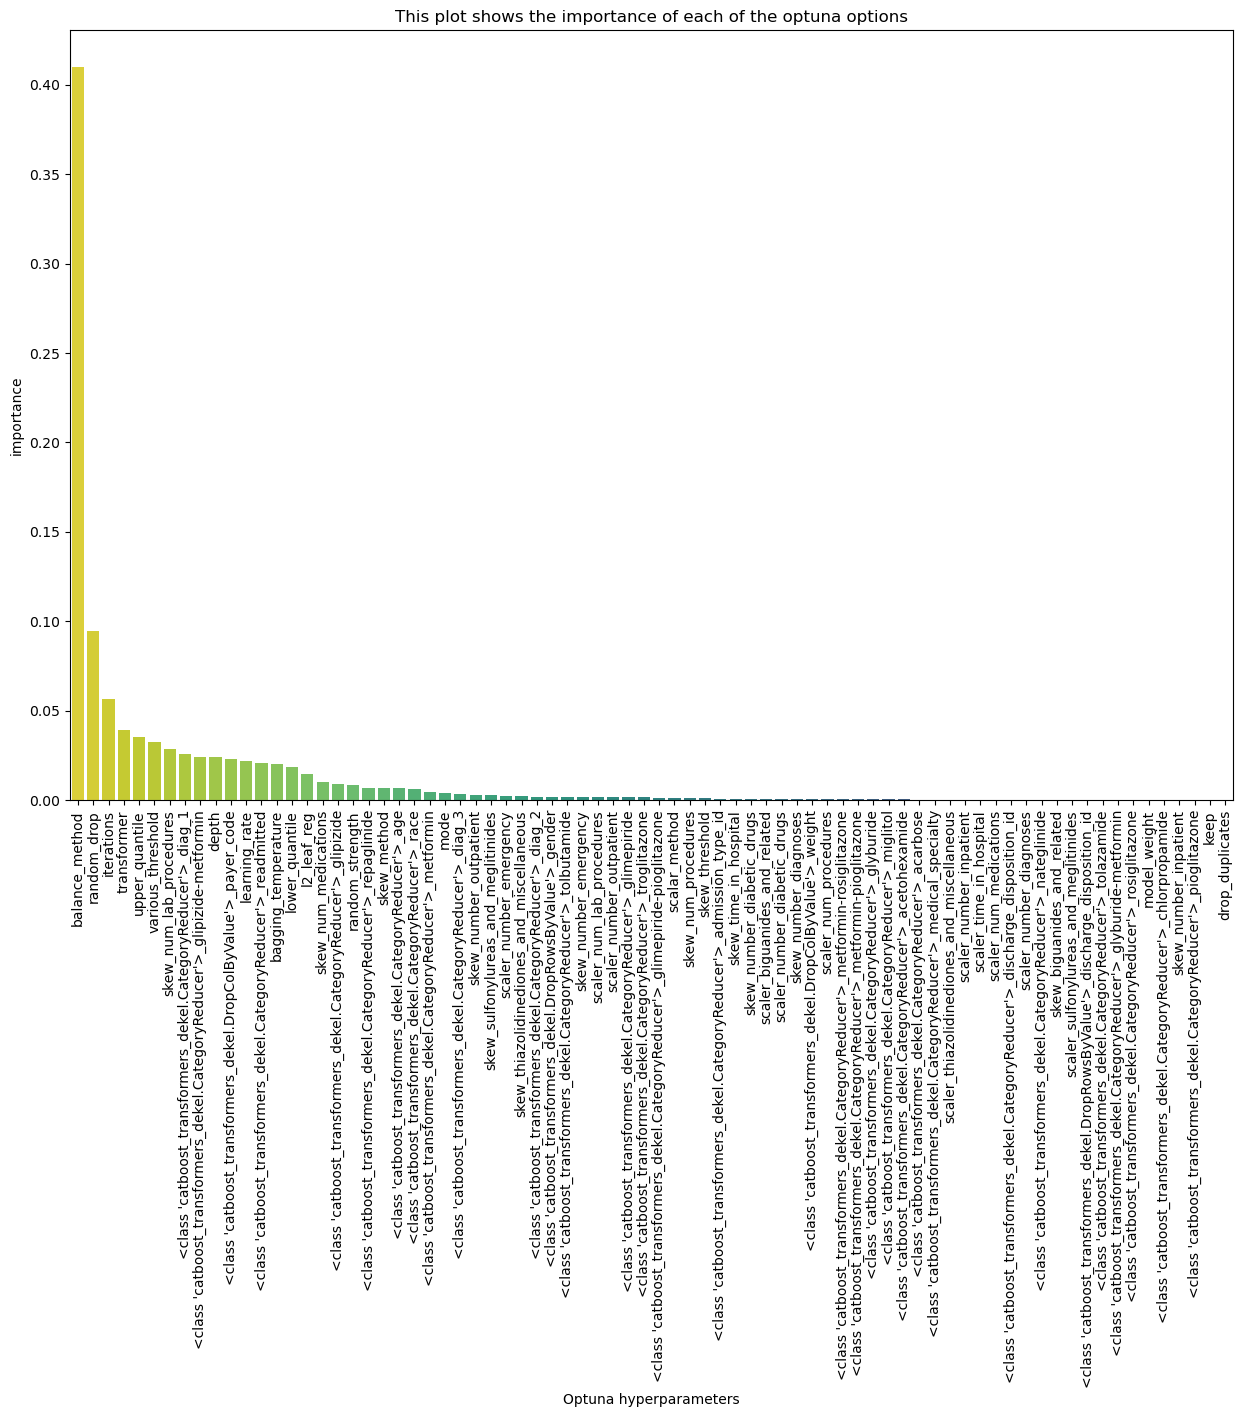

In [15]:
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances

# setting importances
importances = get_param_importances(study)


plt.figure(figsize=(15, 10))
sns.barplot(x=list(importances.keys()), y=list(importances.values()), palette='viridis_r')
plt.xticks(rotation=90)
plt.xlabel('Optuna hyperparameters')
plt.ylabel('importance')
plt.title('This plot shows the importance of each of the optuna options')
plt.savefig('optuna_hyperparameters_importance.png', bbox_inches='tight')
plt.show()



In [23]:
importances

{'balance_method': 0.6063486019018625,
 'random_drop': 0.14987275341397113,
 'transformer': 0.06278978126620767,
 'iterations': 0.03483193896044008,
 'lower_quantile': 0.00913719876738452,
 'bagging_temperature': 0.007869774204796069,
 'learning_rate': 0.007058404124836585,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_3": 0.006120343035731121,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_troglitazone": 0.005732848618791936,
 'scaler_num_procedures': 0.005705182397104155,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glimepiride-pioglitazone": 0.005465634348929389,
 "<class 'catboost_transformers_dekel.DropRowsByValue'>_discharge_disposition_id": 0.005369266662225391,
 'skew_method': 0.0052529709656727545,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glyburide": 0.004854025931311624,
 'upper_quantile': 0.004415427123480528,
 'scaler_number_diagnoses': 0.004260911799432911,
 'skew_num_lab_procedures': 0.004072591717012693,
 'l2_leaf_reg': 0

dict_keys(['balance_method', 'random_drop', 'iterations', 'transformer', 'upper_quantile', 'various_threshold', 'skew_num_lab_procedures', "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1", "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide-metformin", 'depth', "<class 'catboost_transformers_dekel.DropColByValue'>_payer_code", 'learning_rate', "<class 'catboost_transformers_dekel.CategoryReducer'>_readmitted", 'bagging_temperature', 'lower_quantile', 'l2_leaf_reg', 'skew_num_medications', "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide", 'random_strength', "<class 'catboost_transformers_dekel.CategoryReducer'>_repaglinide"])

Text(0.5, 1.0, 'Importance balance_method: 0.41')

Text(0.5, 0, 'balance_method')

Text(0, 0.5, 'value')

Text(0.5, 1.0, 'Importance random_drop: 0.095')

Text(0.5, 0, 'random_drop')

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='iterations'>

Text(0.5, 1.0, 'Importance iterations: 0.057')

Text(0.5, 0, 'iterations')

Text(0, 0.5, 'value')

Text(0.5, 1.0, 'Importance transformer: 0.039')

Text(0.5, 0, 'transformer')

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='upper_quantile'>

Text(0.5, 1.0, 'Importance upper_quantile: 0.035')

Text(0.5, 0, 'upper_quantile')

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='various_threshold'>

Text(0.5, 1.0, 'Importance various_threshold: 0.033')

Text(0.5, 0, 'various_threshold')

Text(0, 0.5, 'value')

Text(0.5, 1.0, 'Importance skew_num_lab_procedures: 0.029')

Text(0.5, 0, 'skew_num_lab_procedures')

Text(0, 0.5, 'value')

Text(0.5, 1.0, "Importance <class 'catboost_transformers_deke\nl.CategoryReducer'>_diag_1: 0.026")

Text(0.5, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1")

Text(0, 0.5, 'value')

Text(0.5, 1.0, "Importance <class 'catboost_transformers_deke\nl.CategoryReducer'>_glipizide-metformin:\n0.024")

Text(0.5, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide-metformin")

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='depth'>

Text(0.5, 1.0, 'Importance depth: 0.024')

Text(0.5, 0, 'depth')

Text(0, 0.5, 'value')

Text(0.5, 1.0, "Importance <class 'catboost_transformers_deke\nl.DropColByValue'>_payer_code: 0.023")

Text(0.5, 0, "<class 'catboost_transformers_dekel.DropColByValue'>_payer_code")

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='learning_rate'>

Text(0.5, 1.0, 'Importance learning_rate: 0.022')

Text(0.5, 0, 'learning_rate')

Text(0, 0.5, 'value')

Text(0.5, 1.0, "Importance <class 'catboost_transformers_deke\nl.CategoryReducer'>_readmitted: 0.021")

Text(0.5, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_readmitted")

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='bagging_temperature'>

Text(0.5, 1.0, 'Importance bagging_temperature: 0.02')

Text(0.5, 0, 'bagging_temperature')

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='lower_quantile'>

Text(0.5, 1.0, 'Importance lower_quantile: 0.018')

Text(0.5, 0, 'lower_quantile')

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='l2_leaf_reg'>

Text(0.5, 1.0, 'Importance l2_leaf_reg: 0.015')

Text(0.5, 0, 'l2_leaf_reg')

Text(0, 0.5, 'value')

Text(0.5, 1.0, 'Importance skew_num_medications: 0.01')

Text(0.5, 0, 'skew_num_medications')

Text(0, 0.5, 'value')

Text(0.5, 1.0, "Importance <class 'catboost_transformers_deke\nl.CategoryReducer'>_glipizide: 0.009")

Text(0.5, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide")

Text(0, 0.5, 'value')

<Axes: xlabel='value', ylabel='random_strength'>

Text(0.5, 1.0, 'Importance random_strength: 0.009')

Text(0.5, 0, 'random_strength')

Text(0, 0.5, 'value')

Text(0.5, 1.0, "Importance <class 'catboost_transformers_deke\nl.CategoryReducer'>_repaglinide: 0.007")

Text(0.5, 0, "<class 'catboost_transformers_dekel.CategoryReducer'>_repaglinide")

Text(0, 0.5, 'value')

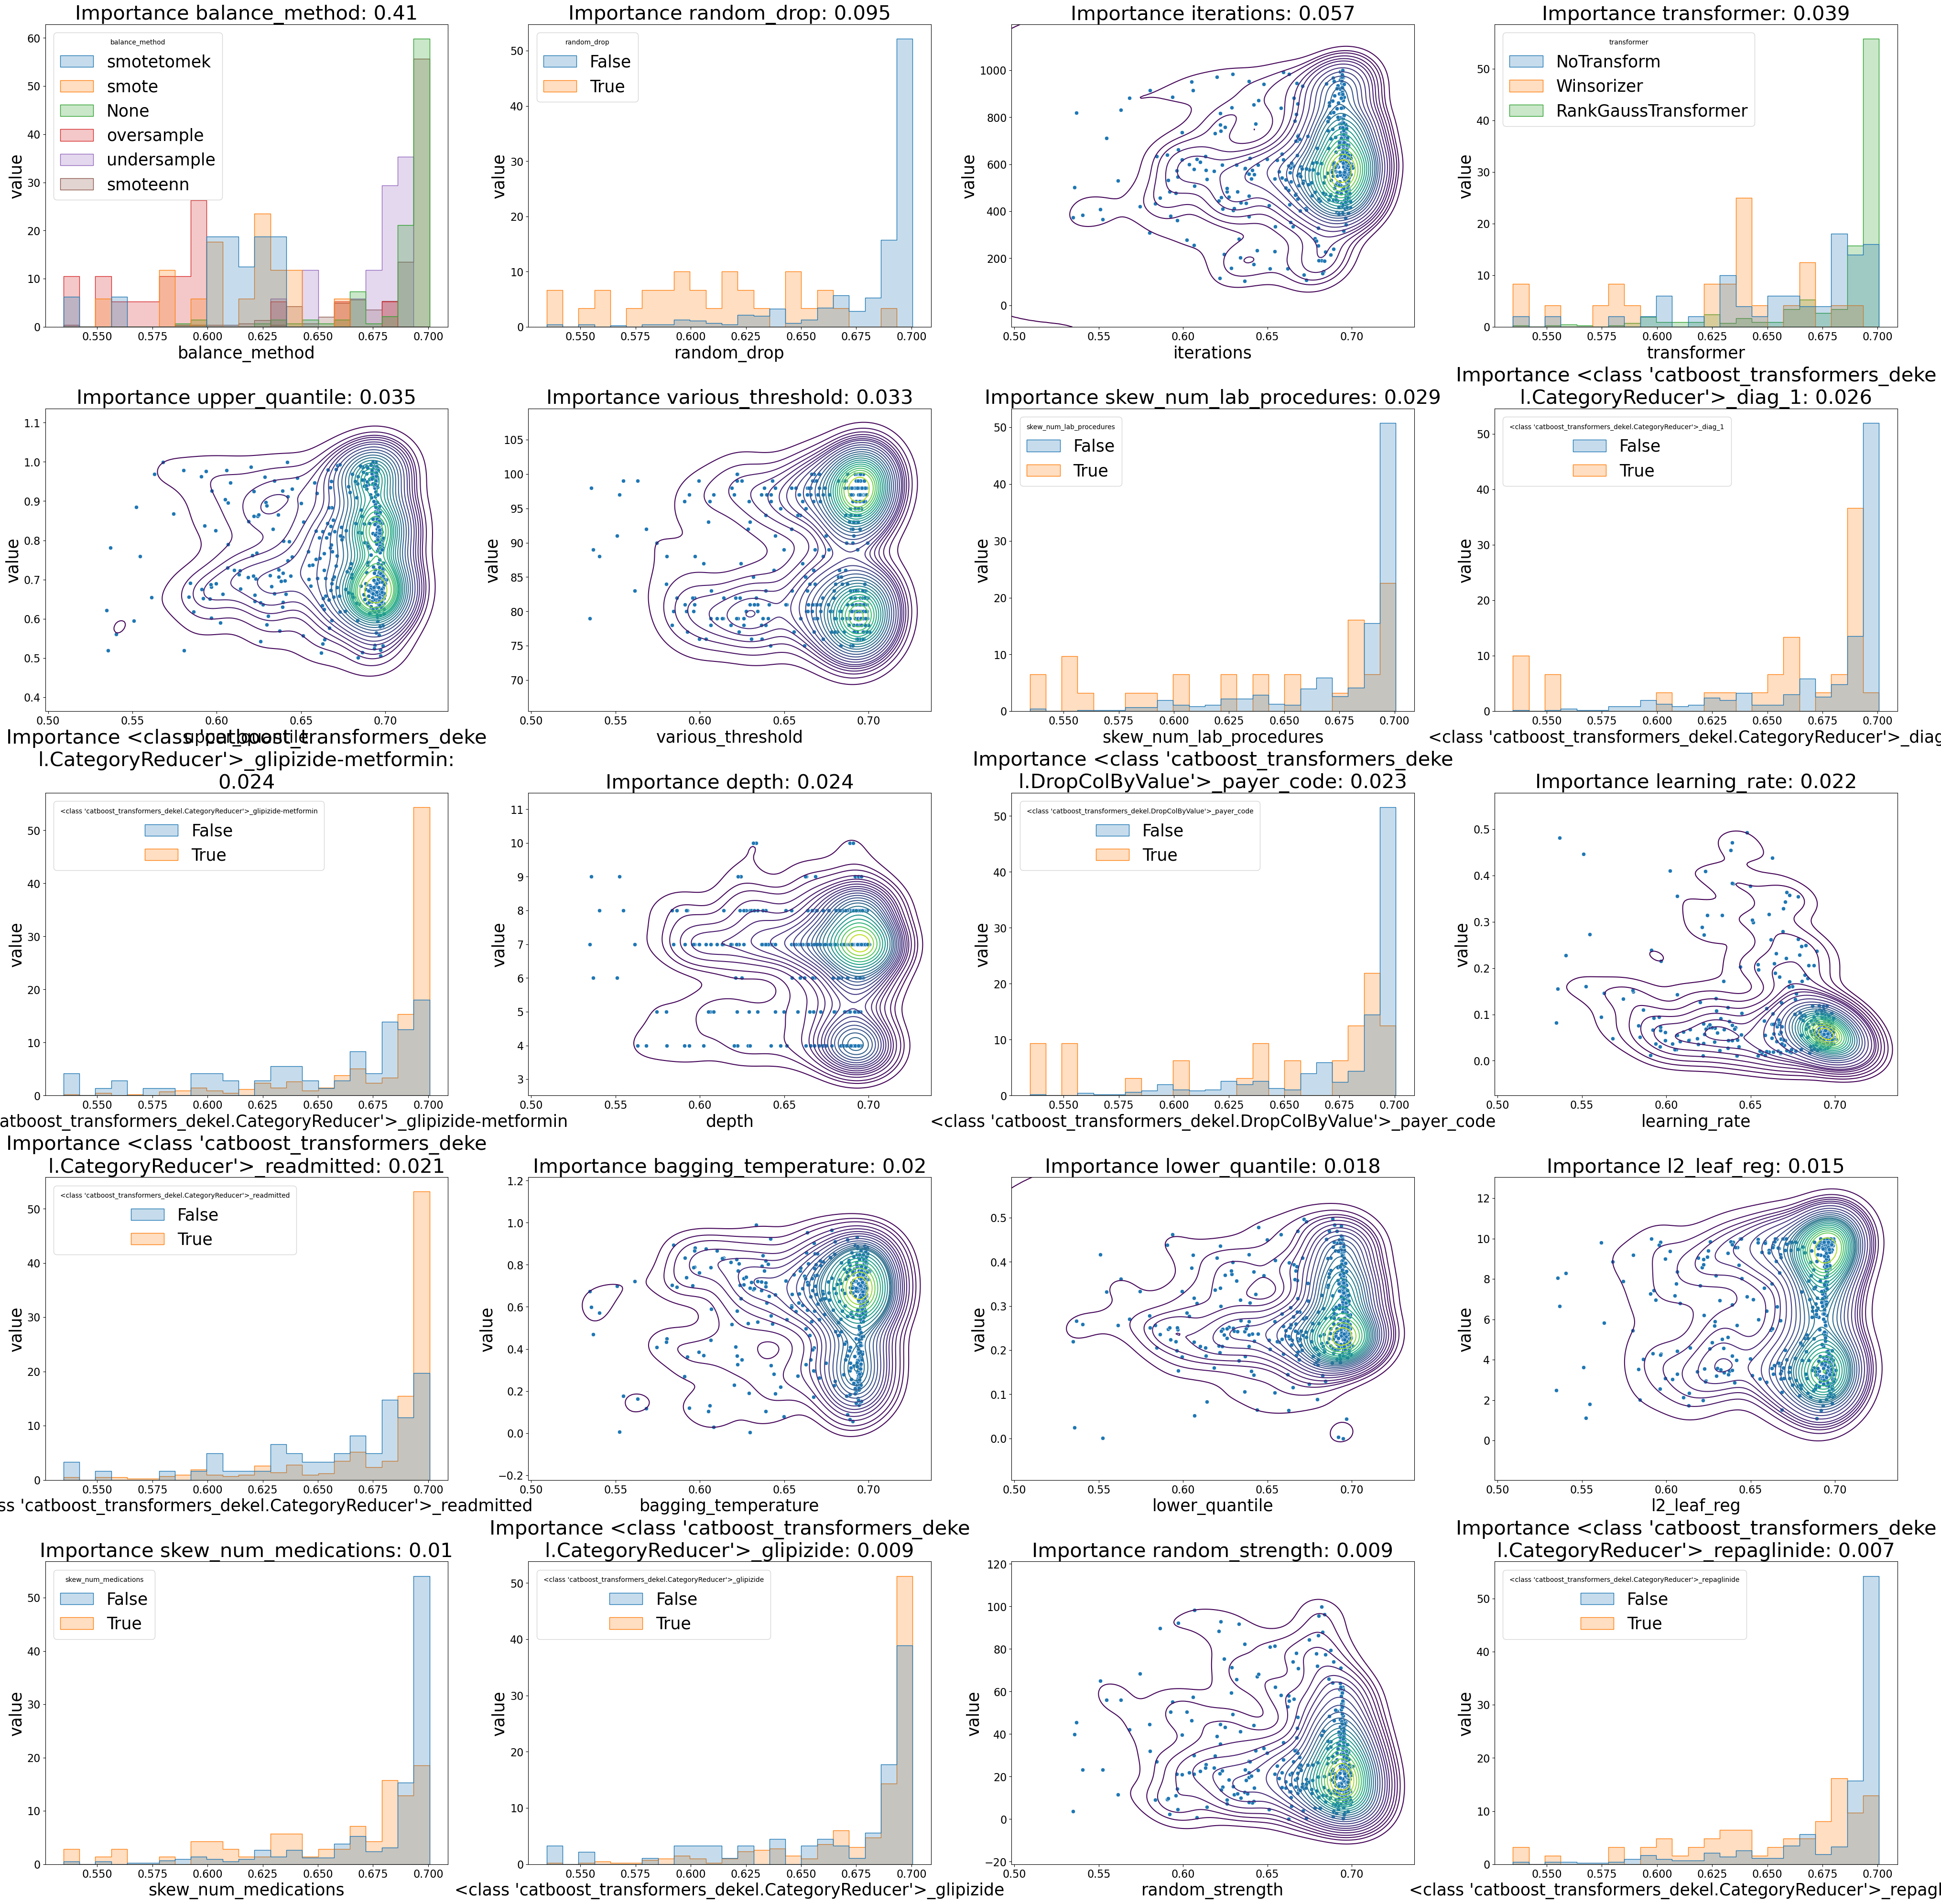

In [19]:
import textwrap

plt.rcParams.update({
    'axes.titlesize': 0,  # Remove the title size
    'axes.labelsize': 20,  # Increase axis label size
    'xtick.labelsize': 16,  # Increase x-tick size
    'ytick.labelsize': 16,  # Increase y-tick size
    'legend.fontsize': 16  # Set legend font size
})

top_20_keys = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True)[:20])
top_20_keys.keys()

trials_df = study.trials_dataframe()
trials_df.columns = [col.replace('params_', '') for col in trials_df.columns]

param_columns = top_20_keys.keys()
n_params = len(param_columns)

# Set up the FacetGrid
n_cols = 4  # Number of plots per row
n_rows = (n_params + n_cols - 1) // n_cols  # Calculate the number of rows needed

f, axes = plt.subplots(n_rows, n_cols, figsize=(12.5*n_cols, 10*n_rows))
f.subplots_adjust(hspace=0.27)  # Add space between rows
axes = axes.flatten()
plots = {}

for index, param in enumerate(param_columns):
    if np.issubdtype(trials_df[param].dtype, np.number):
        plots[index] = sns.scatterplot(data=trials_df, x='value', y=param, ax=axes[index], legend=True)
        sns.kdeplot(data=trials_df, x='value', y=param, ax=plots[index].axes, cmap="viridis", fill=False, thresh=0, levels=25)
    else:
        plots[index] = sns.histplot(data=trials_df, x='value', hue=param, element='step', common_norm=False, stat='percent', ax=axes[index])
    try:
        sns.move_legend(plots[index], 'upper left', fontsize=25)
    except ValueError:
        pass
    title_text = f'Importance {param}: {round(top_20_keys[param], 3)}'
    wrapped_title = '\n'.join(textwrap.wrap(title_text, 45))  # Wrap the title every 45 characters
    axes[index].set_title(wrapped_title, fontsize=30)
    axes[index].set_xlabel(param, fontsize=25)
    axes[index].set_ylabel('value', fontsize=25)

plt.savefig('optuna_hyperparameters_importance_top_20.png', bbox_inches='tight')
plt.show()


In [21]:
# lets get a list of optuna importence
top_20_keys_rounded = {key: round(value, 3) for key, value in top_20_keys.items()}
print(top_20_keys_rounded)

{'balance_method': 0.41, 'random_drop': 0.095, 'iterations': 0.057, 'transformer': 0.039, 'upper_quantile': 0.035, 'various_threshold': 0.033, 'skew_num_lab_procedures': 0.029, "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1": 0.026, "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide-metformin": 0.024, 'depth': 0.024, "<class 'catboost_transformers_dekel.DropColByValue'>_payer_code": 0.023, 'learning_rate': 0.022, "<class 'catboost_transformers_dekel.CategoryReducer'>_readmitted": 0.021, 'bagging_temperature': 0.02, 'lower_quantile': 0.018, 'l2_leaf_reg': 0.015, 'skew_num_medications': 0.01, "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide": 0.009, 'random_strength': 0.009, "<class 'catboost_transformers_dekel.CategoryReducer'>_repaglinide": 0.007}


# from the potuna best parames desterbutions we can see:

1. ether balance the data with smoteenn or don't
2. in most cases the model dont like to randomly drop values - this saing is spasific to the case that letting optuna drop coloumns seuch that each colomn have 50 percent to be droped. 
3. dont use winsorizer when scaling numerical coloumns. the graph shows that ether use ramkgauss or do not use
4. leaving diag 3 withour reduction to classes
5. dont reduse diag1

# 6.2 test best model

In [9]:
study.best_params

{'drop_duplicates': True,
 'keep': 'first',
 "<class 'catboost_transformers_dekel.DropRowsByValue'>_discharge_disposition_id": False,
 "<class 'catboost_transformers_dekel.DropRowsByValue'>_gender": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_2": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_3": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_readmitted": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glyburide-metformin": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glimepiride-pioglitazone": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin-rosiglitazone": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_repaglinide": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_nateglinide": True,
 "<class 'cat

In [36]:
from catboost_transformers_dekel import  DropRowsByValue, ObjectToCategoryTransformer, ChangeValueToValue, CategoryReducer, DropColByValue
from catboost_instantiate_dekel import  instantiate_OutlierTransformer, instantiate_ScalerTransformer, instantiate_SkewFixTransformer, instantiate_GroupCategoriesUsinValues, instantiate_DropColWithLowVarious, instantiate_TransformerLookup, DropDuplicatesTransformer, DropColWithLowVarious, GroupCategoriesUsinValues, SkewFixTransformer, ScalerTransformer, OutlierTransformer, DataFrameImputer, instantiate_DropDuplicatesTransformer

# let's get the test results for our model:
# setting up the lookup for our best model, like in the best parms:
# redussing diag lookup:

lookup_reduse = {
    
    'readmitted': {
        'YES': ['<30'],
        'NO': ['>30', 'NO']
    },
    'metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'nateglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'chlorpropamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acetohexamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },

    'pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'troglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acarbose': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'miglitol': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },

    'glipizide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'race': {
        'AfricanAmerican': ['AfricanAmerican'],
        'Caucasian': ['Caucasian']
    },
}


lookup_row_drop = {}
col_drop = []

group_features_lookup = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    "number_diabetic_drugs": ["biguanides_and_related", "sulfonylureas_and_meglitinides", "thiazolidinediones_and_miscellaneous"]
}


numerical_columns = ['time_in_hospital',
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'biguanides_and_related',
                     'sulfonylureas_and_meglitinides',
                     'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]

columns_to_check_duplicates = ['patient_nbr']


numerical_col_for_scalar =  ['num_procedures', 
                             'number_emergency',
                             'number_inpatient',
                             'number_diagnoses',
                             'biguanides_and_related',
                             'sulfonylureas_and_meglitinides',
                             'number_diabetic_drugs']


numerical_columns_skew = ['num_procedures',
                         'number_diagnoses',
                         'biguanides_and_related',
                         'sulfonylureas_and_meglitinides']







# # Define preprosess pipeline
best_pipe_similar_to_original = Pipeline([
    ('?_to_missing', ChangeValueToValue('?', 'missing')),
    ('nan_to_missing', DataFrameImputer(SimpleImputer(strategy='constant', fill_value='missing'))),
    ('dropduplications', DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep='first')),
    ('droprowbyvalues', DropRowsByValue(lookup=lookup_row_drop)),
    ('categoryreducer', CategoryReducer(lookup=lookup_reduse)),
    ('dropcolbyvalue', DropColByValue(lookup=col_drop)),
    ('drop_high_various', DropColWithLowVarious(various_threshold=77)),
    ('group_features_lookup', GroupCategoriesUsinValues(lookup=group_features_lookup, mode='median')),
    ('skew_fix', SkewFixTransformer(skew_threshold=2.725440752704984, method='QuantileTransformer', numerical_columns=numerical_columns_skew)),
    ('scaler', ScalerTransformer(method='RobustScaler', numerical_columns=numerical_col_for_scalar)),
    ('outlier_transformer', OutlierTransformer(transformer='RankGaussTransformer', lower_quantile=0.2099554296434295, upper_quantile= 0.699716130057308)),
    ('object_to_catagory', ObjectToCategoryTransformer()),
])

cat_boost_params = {'learning_rate': 0.04670099243320657,
 'depth': 7,
 'l2_leaf_reg': 3.487870600435155,
 'bagging_temperature': 0.7685400621464037,
 'random_strength': 24.773008513153833,
 'iterations': 585,
 'early_stopping_rounds': 340,
 'class_weights': [4.337489552893123,  6.4717869665161185]}


def one_hot_model_and_back(X, y, model, random_state=random_state):  
    categorical_columns = list(X.select_dtypes(include=['category', 'object']).columns)
    numerical_columns = list(X.select_dtypes(include=['float', 'int']).columns)  
    
    one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
    one_categorical = one_hot.fit_transform(X[categorical_columns])
    
    uniute_cat_num = np.concatenate([one_categorical, X[numerical_columns].to_numpy()], axis=1)
       
    X_train_balanced, y_train_balanced = model.fit_resample(uniute_cat_num, y)    
    final_onehot_col = one_categorical.shape[1]   
    cat_df = pd.DataFrame(one_hot.inverse_transform(X_train_balanced[:,:final_onehot_col]), columns=categorical_columns)
    num_df = pd.DataFrame(X_train_balanced[:,final_onehot_col:], columns=numerical_columns)
    final_df = pd.concat([cat_df, num_df], axis=1)

    return final_df, y_train_balanced


# setting up balancer

random_state=42
smote = SMOTENC(sampling_strategy='auto', random_state=random_state, categorical_features='auto' )
enn = EditedNearestNeighbours()


X_train, X_test = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df['readmitted'])
X_train = best_pipe_similar_to_original.fit_transform(X_train)

y_train =X_train['readmitted'] == 'YES'
X_train = X_train.drop(columns=['readmitted'])


X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced, y_train_balanced = one_hot_model_and_back(X_train, y_train, enn, random_state)
X_train_balanced = X_train_balanced.reindex(columns=X_train.columns)


cat_indices = X_train_balanced.select_dtypes(include=['category', 'object']).columns.tolist()
best_cat = CatBoostClassifier(cat_features=cat_indices, verbose=False, **cat_boost_params)
best_cat.fit(X_train_balanced, y_train_balanced)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
X_test = best_pipe_similar_to_original.transform(X_test)

y_test = X_test['readmitted'] == 'YES'
X_test = X_test.drop(columns=['readmitted'])

y_pred = best_cat.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, y_pred)


#  cv value: 0.7005933541041718
# test gives 0.619316963984984


In [28]:

random_states = np.random.randint(1, 10000000, size=100)  # Generate 100 random states
roc_auc_scores = []
f1_scores = []

for random_state in tqdm(random_states):
    # Define the balancing methods with the current random state
    smote = SMOTENC(sampling_strategy='auto', random_state=random_state, categorical_features='auto')
    enn = EditedNearestNeighbours()
    
    # Split the data
    X_train, X_test = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df['readmitted'])
    X_train = best_pipe_similar_to_original.fit_transform(X_train)
    
    y_train = X_train['readmitted'] == 'YES'
    X_train = X_train.drop(columns=['readmitted'])
    
    # Balance the training data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    X_train_balanced, y_train_balanced = one_hot_model_and_back(X_train_balanced, y_train_balanced, enn, random_state)
    X_train_balanced = X_train_balanced.reindex(columns=X_train.columns)
    
    # Define categorical indices for CatBoost
    cat_indices = X_train_balanced.select_dtypes(include=['category', 'object']).columns.tolist()
    
    # Train the CatBoost model
    best_cat = CatBoostClassifier(cat_features=cat_indices, verbose=False, **cat_boost_params)
    best_cat.fit(X_train_balanced, y_train_balanced)
    
    # Prepare the test set
    X_test = best_pipe_similar_to_original.transform(X_test)
    y_test = X_test['readmitted'] == 'YES'
    X_test = X_test.drop(columns=['readmitted'])
    
    # Predict probabilities
    y_pred_proba = best_cat.predict_proba(X_test)[:, 1]
    y_pred = best_cat.predict(X_test)
    
    # Calculate scores
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Append scores to the lists
    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)

# Print average scores
print(f'Average ROC AUC Score: {np.mean(roc_auc_scores):.3f}')
print(f'Average F1 Score: {np.mean(f1_scores):.3f}')

  0%|                                                                                                                                                                  | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [02:23<3:56:13, 143.17s/it]

  2%|███                                                                                                                                                    | 2/100 [04:46<3:54:01, 143.28s/it]

  3%|████▌                                                                                                                                                  | 3/100 [07:09<3:51:07, 142.97s/it]

  4%|██████                                                                                                                                                 | 4/100 [09:37<3:52:16, 145.17s/it]

  5%|███████▌                                                                                                                                               | 5/100 [12:04<3:51:01, 145.92s/it]

  6%|█████████                                                                                                                                              | 6/100 [14:31<3:49:07, 146.25s/it]

  7%|██████████▌                                                                                                                                            | 7/100 [16:59<3:47:16, 146.63s/it]

  8%|████████████                                                                                                                                           | 8/100 [19:30<3:47:00, 148.05s/it]

  9%|█████████████▌                                                                                                                                         | 9/100 [21:58<3:44:45, 148.20s/it]

 10%|███████████████                                                                                                                                       | 10/100 [24:26<3:42:07, 148.08s/it]

 11%|████████████████▌                                                                                                                                     | 11/100 [26:48<3:36:39, 146.07s/it]

 12%|██████████████████                                                                                                                                    | 12/100 [29:14<3:34:18, 146.11s/it]

 13%|███████████████████▌                                                                                                                                  | 13/100 [31:37<3:30:45, 145.35s/it]

 14%|█████████████████████                                                                                                                                 | 14/100 [33:59<3:26:50, 144.31s/it]

 15%|██████████████████████▌                                                                                                                               | 15/100 [36:32<3:27:53, 146.75s/it]

 16%|████████████████████████                                                                                                                              | 16/100 [38:54<3:23:29, 145.35s/it]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [41:21<3:21:43, 145.82s/it]

 18%|███████████████████████████                                                                                                                           | 18/100 [43:51<3:21:14, 147.25s/it]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [46:26<3:21:43, 149.42s/it]

 20%|██████████████████████████████                                                                                                                        | 20/100 [49:05<3:23:15, 152.45s/it]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [51:34<3:19:08, 151.25s/it]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [54:02<3:15:15, 150.20s/it]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [56:32<3:12:45, 150.20s/it]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [59:01<3:09:51, 149.88s/it]

 25%|█████████████████████████████████████                                                                                                               | 25/100 [1:01:32<3:07:42, 150.16s/it]

 26%|██████████████████████████████████████▍                                                                                                             | 26/100 [1:04:00<3:04:37, 149.70s/it]

 27%|███████████████████████████████████████▉                                                                                                            | 27/100 [1:06:31<3:02:32, 150.04s/it]

 28%|█████████████████████████████████████████▍                                                                                                          | 28/100 [1:09:02<3:00:10, 150.15s/it]

 29%|██████████████████████████████████████████▉                                                                                                         | 29/100 [1:11:31<2:57:30, 150.00s/it]

 30%|████████████████████████████████████████████▍                                                                                                       | 30/100 [1:14:02<2:55:20, 150.30s/it]

 31%|█████████████████████████████████████████████▉                                                                                                      | 31/100 [1:16:33<2:52:55, 150.37s/it]

 32%|███████████████████████████████████████████████▎                                                                                                    | 32/100 [1:19:02<2:50:11, 150.17s/it]

 33%|████████████████████████████████████████████████▊                                                                                                   | 33/100 [1:21:33<2:47:42, 150.19s/it]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 34/100 [1:24:06<2:46:17, 151.17s/it]

 35%|███████████████████████████████████████████████████▊                                                                                                | 35/100 [1:26:36<2:43:13, 150.67s/it]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 36/100 [1:29:03<2:39:46, 149.79s/it]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 37/100 [1:31:33<2:37:14, 149.75s/it]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 38/100 [1:34:02<2:34:33, 149.58s/it]

 39%|█████████████████████████████████████████████████████████▋                                                                                          | 39/100 [1:36:33<2:32:24, 149.91s/it]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 40/100 [1:39:02<2:29:48, 149.81s/it]

 41%|████████████████████████████████████████████████████████████▋                                                                                       | 41/100 [1:41:30<2:26:38, 149.13s/it]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 42/100 [1:44:00<2:24:19, 149.30s/it]

 43%|███████████████████████████████████████████████████████████████▋                                                                                    | 43/100 [1:46:27<2:21:21, 148.81s/it]

 44%|█████████████████████████████████████████████████████████████████                                                                                   | 44/100 [1:48:55<2:18:27, 148.35s/it]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 45/100 [1:51:24<2:16:10, 148.55s/it]

 46%|████████████████████████████████████████████████████████████████████                                                                                | 46/100 [1:53:49<2:12:48, 147.57s/it]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                              | 47/100 [1:56:18<2:10:43, 147.99s/it]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [1:58:46<2:08:13, 147.95s/it]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                           | 49/100 [2:01:12<2:05:22, 147.51s/it]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 50/100 [2:03:42<2:03:24, 148.08s/it]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                        | 51/100 [2:06:14<2:01:53, 149.25s/it]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                       | 52/100 [2:08:45<2:00:00, 150.02s/it]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                     | 53/100 [2:11:12<1:56:38, 148.90s/it]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 54/100 [2:13:38<1:53:26, 147.97s/it]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                  | 55/100 [2:16:07<1:51:13, 148.30s/it]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 56/100 [2:18:34<1:48:28, 147.92s/it]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                               | 57/100 [2:21:02<1:46:00, 147.92s/it]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                              | 58/100 [2:23:29<1:43:24, 147.72s/it]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                            | 59/100 [2:25:55<1:40:37, 147.25s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 60/100 [2:28:22<1:38:09, 147.25s/it]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 61/100 [2:30:49<1:35:34, 147.05s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 62/100 [2:33:18<1:33:30, 147.64s/it]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 63/100 [2:35:46<1:31:04, 147.68s/it]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 64/100 [2:38:15<1:28:56, 148.23s/it]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 65/100 [2:40:44<1:26:38, 148.52s/it]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 66/100 [2:43:11<1:23:50, 147.95s/it]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 67/100 [2:45:37<1:21:06, 147.46s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 68/100 [2:48:03<1:18:27, 147.10s/it]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 69/100 [2:50:33<1:16:21, 147.80s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 70/100 [2:53:03<1:14:16, 148.55s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 71/100 [2:55:26<1:10:53, 146.68s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [2:57:51<1:08:16, 146.32s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 73/100 [3:00:16<1:05:40, 145.95s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 74/100 [3:02:43<1:03:19, 146.13s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 75/100 [3:05:13<1:01:25, 147.43s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [3:07:42<59:09, 147.89s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [3:10:10<56:39, 147.82s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [3:12:42<54:39, 149.06s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [3:15:14<52:32, 150.13s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [3:17:38<49:20, 148.05s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [3:20:00<46:18, 146.25s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [3:22:21<43:28, 144.94s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [3:24:42<40:40, 143.55s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [3:27:03<38:05, 142.84s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [3:29:25<35:39, 142.62s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [3:31:47<33:12, 142.33s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [3:34:09<30:51, 142.42s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [3:36:32<28:30, 142.52s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [3:38:57<26:14, 143.18s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [3:41:20<23:52, 143.27s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [3:43:45<21:32, 143.58s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [3:46:11<19:15, 144.39s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [3:48:33<16:45, 143.68s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [3:50:54<14:18, 143.00s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [3:53:16<11:52, 142.49s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [3:55:39<09:31, 142.87s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [3:58:06<07:11, 143.88s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [4:00:31<04:48, 144.39s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [4:02:55<02:24, 144.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:05:20<00:00, 147.21s/it]

Average ROC AUC Score: 0.579
Average F1 Score: 0.188


<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Test AUC 100 samples with changing seed')

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Test F1 100 samples with changing seed')

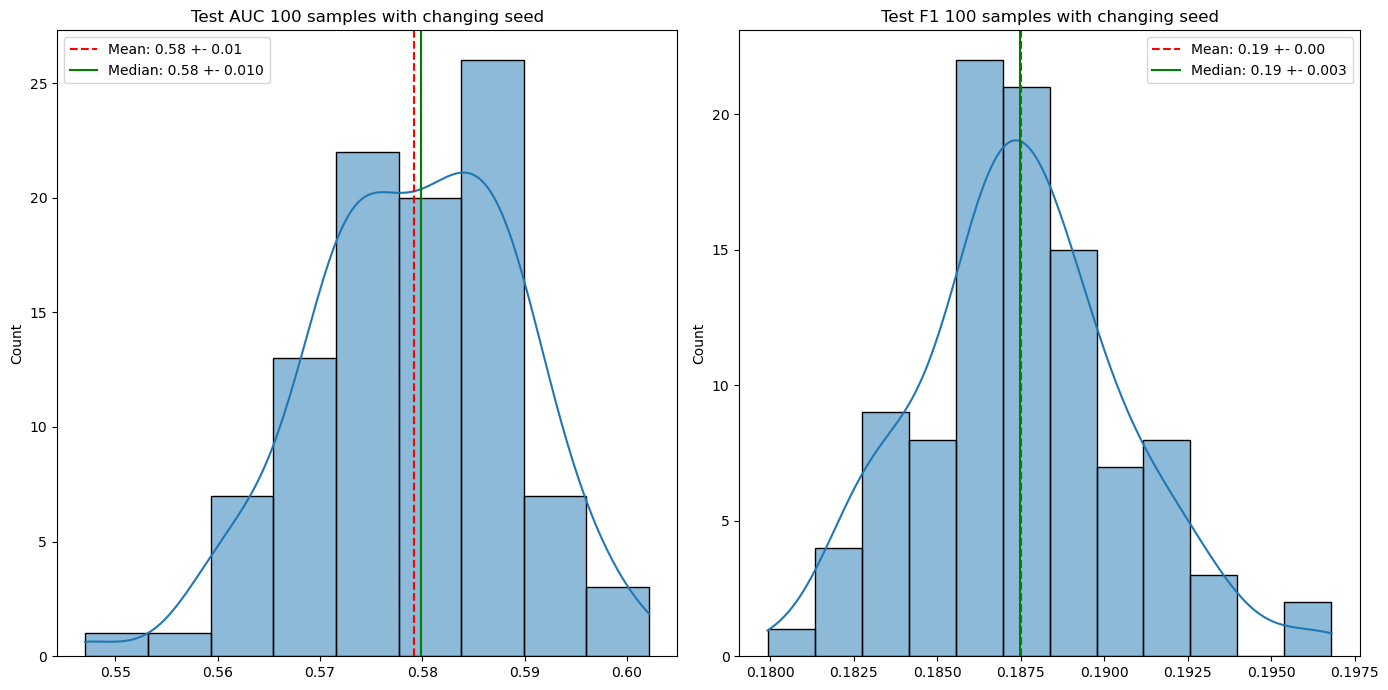

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the parameters for the normal distribution
mean = 0.66
std_dev = 0.03
size = 1000  # Adjust this value to generate more or fewer samples

# Generate two sets of normal distributions
samples1 = roc_auc_scores
samples2 = f1_scores

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the first histogram
sns.histplot(samples1, kde=True, ax=axes[0])
axes[0].axvline(np.mean(samples1), color='r', linestyle='--', label=f'Mean: {np.mean(samples1):.2f} +- {np.std(samples1):.2f}')
axes[0].axvline(np.median(samples1), color='g', linestyle='-', label=f'Median: {np.median(samples1):.2f} +- {np.std(samples1):.3f}')
axes[0].legend()
axes[0].set_title('Test AUC 100 samples with changing seed')

# Plot the second histogram
sns.histplot(samples2, kde=True, ax=axes[1])
axes[1].axvline(np.mean(samples2), color='r', linestyle='--', label=f'Mean: {np.mean(samples2):.2f} +- {np.std(samples2):.2f}')
axes[1].axvline(np.median(samples2), color='g', linestyle='-', label=f'Median: {np.median(samples2):.2f} +- {np.std(samples2):.3f}')
axes[1].legend()
axes[1].set_title('Test F1 100 samples with changing seed')

# Show the plot
plt.tight_layout()
plt.savefig('model_test_results', bbox_inches='tight')
plt.show()


<Figure size 1000x800 with 0 Axes>

<BarContainer object of 52 artists>

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Feature Importance - Best model ')

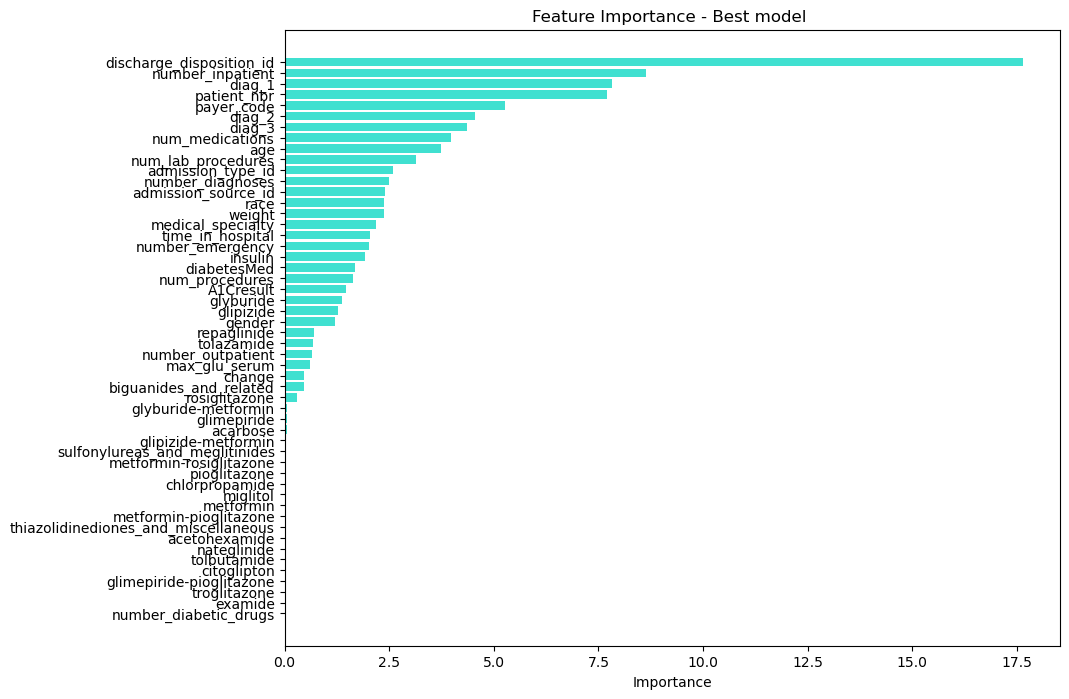

In [37]:

#  lets look at the model's importens features:
feature_importances = best_cat.get_feature_importance()
feature_names = X_test.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='turquoise')
plt.xlabel('Importance')
plt.title('Feature Importance - Best model ')
plt.gca().invert_yaxis()

plt.savefig('model_Feature_importance', bbox_inches='tight')
plt.show()

In this model, I can see that payer_code has high importance. This doesn't have a logical reason, so I tried to change the model a bit and removed the payer_code. Another change I made was to remove discharge_disposition_id values as described in the original model's preprocessing.

In [104]:
# let's get the test results for our model with the changes above:

# study.best_params:
"""
{'drop_duplicates': True,
 'keep': 'first',
 "<class 'catboost_transformers_dekel.DropRowsByValue'>_discharge_disposition_id": True,
 "<class 'catboost_transformers_dekel.DropRowsByValue'>_gender": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_1": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_2": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_diag_3": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_readmitted": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glyburide-metformin": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glimepiride-pioglitazone": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin-rosiglitazone": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_repaglinide": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_nateglinide": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_chlorpropamide": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glimepiride": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_acetohexamide": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glyburide": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_tolbutamide": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_pioglitazone": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_rosiglitazone": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_troglitazone": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_acarbose": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_miglitol": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_tolazamide": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_glipizide-metformin": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_metformin-pioglitazone": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_discharge_disposition_id": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_admission_type_id": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_race": False,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_age": True,
 "<class 'catboost_transformers_dekel.CategoryReducer'>_medical_specialty": True,
 "<class 'catboost_transformers_dekel.DropColByValue'>_weight": False,
 "<class 'catboost_transformers_dekel.DropColByValue'>_payer_code": True,
 'mode': 'median',
 'skew_method': 'NoTransform',
 'scaler_time_in_hospital': True,
 'scaler_num_lab_procedures': False,
 'scaler_num_procedures': False,
 'scaler_num_medications': True,
 'scaler_number_outpatient': True,
 'scaler_number_emergency': True,
 'scaler_number_inpatient': True,
 'scaler_number_diagnoses': False,
 'scaler_biguanides_and_related': False,
 'scaler_sulfonylureas_and_meglitinides': True,
 'scaler_thiazolidinediones_and_miscellaneous': False,
 'scaler_number_diabetic_drugs': True,
 'scalar_method': 'StandardScaler',
 'transformer': 'RankGaussTransformer',
 'lower_quantile': 0.04530088305871175,
 'upper_quantile': 0.5189956018071391,
 'random_drop': False,
 'learning_rate': 0.025849438608491645,
 'depth': 9,
 'l2_leaf_reg': 6.046601836066566,
 'bagging_temperature': 0.4950862687089907,
 'random_strength': 29.81814888818526,
 'iterations': 801,
 'early_stopping_rounds': 435,
 'model_weight': False,
 'balance_method': 'smoteenn'}
 'various_threshold': 97,
"""


# setting up the lookup for our best model, like in the best parms:
lookup_reduse = {
    
    
    'readmitted': {
        'YES': ['<30'],
        'NO': ['>30', 'NO']
    },
    
    'glimepiride-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
   
    'repaglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'nateglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'chlorpropamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    
    'tolbutamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'troglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    
    
    'glipizide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
   
    'age': {
        '<30': ['[0-10)', '[10-20)', '[20-30)'],
        '30<60': ['[30-40)', '[40-50)', '[50-60)'],
        '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']
    },
    'medical_specialty': {
        "InternalMedicine": ['InternalMedicine'],
        'Emergency/Trauma': ['Emergency/Trauma'],
        'Family/GeneralPractice': ['Family/GeneralPractice'],
        'Cardiology': ['Cardiology'],
        'Surgery-General': ['Surgery-General'],
        'Nephrology': ['Nephrology'],
        'Orthopedics': ['Orthopedics']
    }
}

medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})
lookup_row_drop = {'discharge_disposition_id': [11, 13, 14, 19, 20, 21]}

col_drop = ['patient_nbr', 'payer_code']

group_features_lookup = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    "number_diabetic_drugs": ["biguanides_and_related", "sulfonylureas_and_meglitinides", "thiazolidinediones_and_miscellaneous"]
}

numerical_columns = ['time_in_hospital',
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'biguanides_and_related',
                     'sulfonylureas_and_meglitinides',
                     'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]

columns_to_check_duplicates = ['patient_nbr']


numerical_col_for_scalar =  ['time_in_hospital',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',                 
                     'sulfonylureas_and_meglitinides',
                     'number_diabetic_drugs'
                    ]


# # Define preprosess pipeline
best_pipe_similar_to_original = Pipeline([
    ('?_to_missing', ChangeValueToValue('?', 'missing')),
    ('nan_to_missing', DataFrameImputer(SimpleImputer(strategy='constant', fill_value='missing'))),
    ('dropduplications', DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep='first')),
    ('droprowbyvalues', DropRowsByValue(lookup=lookup_row_drop)),
    ('categoryreducer', CategoryReducer(lookup=lookup_reduse)),
    ('dropcolbyvalue', DropColByValue(lookup=col_drop)),
    ('group_features_lookup', GroupCategoriesUsinValues(lookup=group_features_lookup, mode='median')),
    ('scaler', ScalerTransformer(method='StandardScaler', numerical_columns=numerical_col_for_scalar)),
    ('outlier_transformer', OutlierTransformer(transformer='RankGaussTransformer', lower_quantile=0.04530088305871175, upper_quantile= 0.5189956018071391)),
    ('drop_high_various', DropColWithLowVarious(various_threshold=97)),
    ('object_to_catagory', ObjectToCategoryTransformer()),
])

# setting up balancer

random_state=42
smote = SMOTENC(sampling_strategy='auto', random_state=random_state, categorical_features='auto' )
enn = EditedNearestNeighbours()

               

# setting catboost
cat_boost_params = {'learning_rate': 0.025849438608491645,
 'depth': 9,
 'l2_leaf_reg': 6.046601836066566,
 'bagging_temperature': 0.4950862687089907,
 'random_strength': 29.81814888818526,
 'iterations': 801,
 'early_stopping_rounds': 435}




def one_hot_model_and_back(X, y, model, random_state=42):  
    categorical_columns = list(X.select_dtypes(include=['category', 'object']).columns)
    numerical_columns = list(X.select_dtypes(include=['float', 'int']).columns)  
    
    one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
    one_categorical = one_hot.fit_transform(X[categorical_columns])
    
    uniute_cat_num = np.concatenate([one_categorical, X[numerical_columns].to_numpy()], axis=1)
       
    X_train_balanced, y_train_balanced = model.fit_resample(uniute_cat_num, y)    
    final_onehot_col = one_categorical.shape[1]   
    cat_df = pd.DataFrame(one_hot.inverse_transform(X_train_balanced[:,:final_onehot_col]), columns=categorical_columns)
    num_df = pd.DataFrame(X_train_balanced[:,final_onehot_col:], columns=numerical_columns)
    final_df = pd.concat([cat_df, num_df], axis=1)

    return final_df, y_train_balanced




# lets look at the test results of the best parameters:

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['readmitted'])


X_train = best_pipe_similar_to_original.fit_transform(X_train)
y_train =X_train['readmitted']
X_train = X_train.drop(columns=['readmitted'])


X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced, y_train_balanced = one_hot_model_and_back(X_train, y_train, enn, random_state)
X_train_balanced = X_train_balanced.reindex(columns=X_train.columns)

cat_indices = X_train_balanced.select_dtypes(include=['category', 'object']).columns.tolist()
best_cat = CatBoostClassifier(cat_features=cat_indices, verbose=False, **cat_boost_params)
best_cat.fit(X_train_balanced, y_train_balanced)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
X_test = best_pipe_similar_to_original.transform(X_test)

y_test =X_test['readmitted']
X_test = X_test.drop(columns=['readmitted'])

y_pred = best_cat.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(score)

#  cv value: 0.6986640647182665
# test gives 0.6359536816180944


'\n{\'drop_duplicates\': True,\n \'keep\': \'first\',\n "<class \'catboost_transformers_dekel.DropRowsByValue\'>_discharge_disposition_id": False,\n "<class \'catboost_transformers_dekel.DropRowsByValue\'>_gender": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_diag_1": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_diag_2": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_diag_3": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_readmitted": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_metformin": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_glyburide-metformin": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_glimepiride-pioglitazone": True,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_metformin-rosiglitazone": False,\n "<class \'catboost_transformers_dekel.CategoryReducer\'>_repaglinide": True,\n "<class \'catboost_transformers_dekel.Categ

0.6359536816180944


<Figure size 1000x800 with 0 Axes>

<BarContainer object of 30 artists>

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Feature Importance - CatBoost')

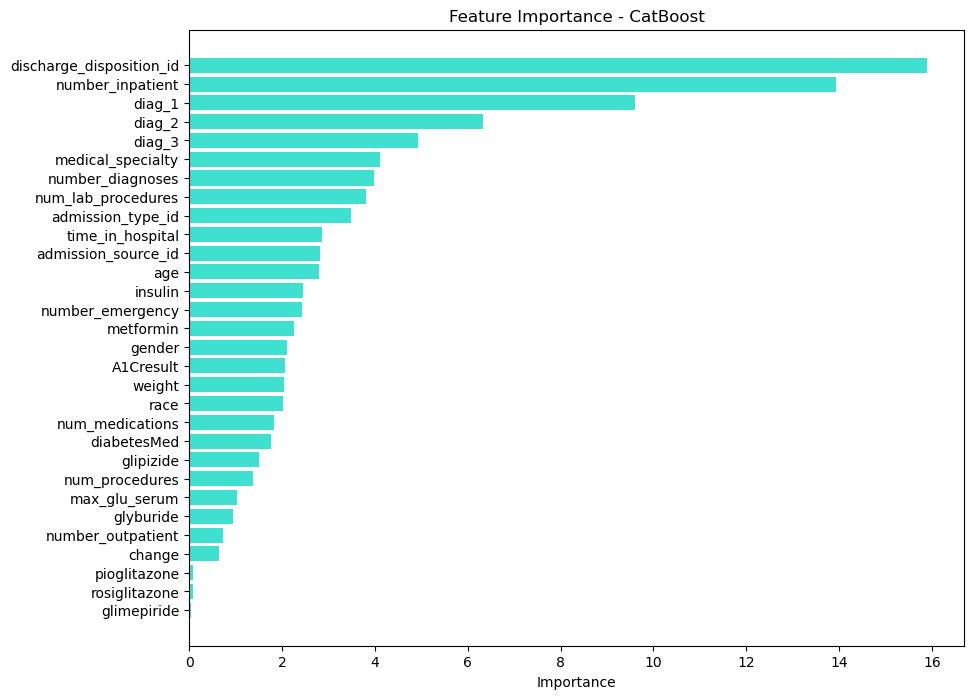

In [105]:

#  lets look at the model's importens features:
feature_importances = best_cat.get_feature_importance()
feature_names = X_test.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='turquoise')
plt.xlabel('Importance')
plt.title('Feature Importance - CatBoost')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# after changing the model I see that there was not a big diffrence, in the test result.
# now I can see that the importence of the model is logic

In [55]:
from catboost_transformers_dekel import  DropRowsByValue, ObjectToCategoryTransformer, ChangeValueToValue, CategoryReducer, DropColByValue
from catboost_instantiate_dekel import  instantiate_OutlierTransformer, instantiate_ScalerTransformer, instantiate_SkewFixTransformer, instantiate_GroupCategoriesUsinValues, instantiate_DropColWithLowVarious, instantiate_TransformerLookup, DropDuplicatesTransformer, DropColWithLowVarious, GroupCategoriesUsinValues, SkewFixTransformer, ScalerTransformer, OutlierTransformer, DataFrameImputer, instantiate_DropDuplicatesTransformer

# let's get the test results for our model:
# setting up the lookup for our best model, like in the best parms:
# redussing diag lookup:

lookup_reduse = {
    
    'readmitted': {
        'YES': ['<30'],
        'NO': ['>30', 'NO']
    },
    'metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'nateglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'chlorpropamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acetohexamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },

    'pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'troglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acarbose': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'miglitol': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },

    'glipizide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'race': {
        'AfricanAmerican': ['AfricanAmerican'],
        'Caucasian': ['Caucasian']
    },
}




group_features_lookup = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    "number_diabetic_drugs": ["biguanides_and_related", "sulfonylureas_and_meglitinides", "thiazolidinediones_and_miscellaneous"]
}


numerical_columns = ['time_in_hospital',
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'biguanides_and_related',
                     'sulfonylureas_and_meglitinides',
                     'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]

columns_to_check_duplicates = ['patient_nbr']


numerical_col_for_scalar =  ['num_procedures', 
                             'number_emergency',
                             'number_inpatient',
                             'number_diagnoses',
                             'biguanides_and_related',
                             'sulfonylureas_and_meglitinides',
                             'number_diabetic_drugs']


numerical_columns_skew = ['num_procedures',
                         'number_diagnoses',
                         'biguanides_and_related',
                         'sulfonylureas_and_meglitinides']

lookup_row_drop = {
    'discharge_disposition_id': [11, 13, 14, 19, 20, 21]
}

col_drop = ['payer_code', 'patient_nbr']





# # Define preprosess pipeline
best_pipe_similar_to_original = Pipeline([
    ('?_to_missing', ChangeValueToValue('?', 'missing')),
    ('nan_to_missing', DataFrameImputer(SimpleImputer(strategy='constant', fill_value='missing'))),
    ('dropduplications', DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep='first')),
    ('droprowbyvalues', DropRowsByValue(lookup=lookup_row_drop)),
    ('categoryreducer', CategoryReducer(lookup=lookup_reduse)),
    
    ('drop_high_various', DropColWithLowVarious(various_threshold=77)),
    ('group_features_lookup', GroupCategoriesUsinValues(lookup=group_features_lookup, mode='median')),
    ('skew_fix', SkewFixTransformer(skew_threshold=2.725440752704984, method='QuantileTransformer', numerical_columns=numerical_columns_skew)),
    ('scaler', ScalerTransformer(method='RobustScaler', numerical_columns=numerical_col_for_scalar)),
    ('outlier_transformer', OutlierTransformer(transformer='RankGaussTransformer', lower_quantile=0.2099554296434295, upper_quantile= 0.699716130057308)),
    ('object_to_catagory', ObjectToCategoryTransformer()),
    ('dropcolbyvalue', DropColByValue(lookup=col_drop)),
])

cat_boost_params = {'learning_rate': 0.04670099243320657,
 'depth': 7,
 'l2_leaf_reg': 3.487870600435155,
 'bagging_temperature': 0.7685400621464037,
 'random_strength': 24.773008513153833,
 'iterations': 585,
 'early_stopping_rounds': 340,
 'class_weights': [4.337489552893123,  6.4717869665161185]}


def one_hot_model_and_back(X, y, model):  
    categorical_columns = list(X.select_dtypes(include=['category', 'object']).columns)
    numerical_columns = list(X.select_dtypes(include=['float', 'int']).columns)  
    
    one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)
    one_categorical = one_hot.fit_transform(X[categorical_columns])
    
    uniute_cat_num = np.concatenate([one_categorical, X[numerical_columns].to_numpy()], axis=1)
       
    X_train_balanced, y_train_balanced = model.fit_resample(uniute_cat_num, y)    
    final_onehot_col = one_categorical.shape[1]   
    cat_df = pd.DataFrame(one_hot.inverse_transform(X_train_balanced[:,:final_onehot_col]), columns=categorical_columns)
    num_df = pd.DataFrame(X_train_balanced[:,final_onehot_col:], columns=numerical_columns)
    final_df = pd.concat([cat_df, num_df], axis=1)

    return final_df, y_train_balanced


# setting up balancer

random_state=42
smote = SMOTENC(sampling_strategy='auto', random_state=random_state, categorical_features='auto' )
enn = EditedNearestNeighbours()


X_train, X_test = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df['readmitted'])
X_train = best_pipe_similar_to_original.fit_transform(X_train)

y_train =X_train['readmitted'] == 'YES'
X_train = X_train.drop(columns=['readmitted'])


X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# X_train_balanced, y_train_balanced = one_hot_model_and_back(X_train, y_train, enn)
X_train_balanced = X_train_balanced.reindex(columns=X_train.columns)


cat_indices = X_train_balanced.select_dtypes(include=['category', 'object']).columns.tolist()
best_cat = CatBoostClassifier(cat_features=cat_indices, verbose=False, **cat_boost_params)
best_cat.fit(X_train_balanced, y_train_balanced)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
X_test = best_pipe_similar_to_original.transform(X_test)

y_test = X_test['readmitted'] == 'YES'
X_test = X_test.drop(columns=['readmitted'])

y_pred = best_cat.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, y_pred)


#  cv value: 0.7005933541041718
# test gives 0.6143641746642448


In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_cat.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

In [63]:
cm = np.array([[6.4, 3.6], [4, 6]])

Confusion Matrix:
[[6.4 3.6]
 [4.  6. ]]
Normalized Confusion Matrix:
[[0.64 0.36]
 [0.4  0.6 ]]
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.07      0.13     16096
        True       0.10      0.95      0.18      1807

    accuracy                           0.16     17903
   macro avg       0.51      0.51      0.16     17903
weighted avg       0.84      0.16      0.14     17903



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted')

Text(70.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Normalized Confusion Matrix')

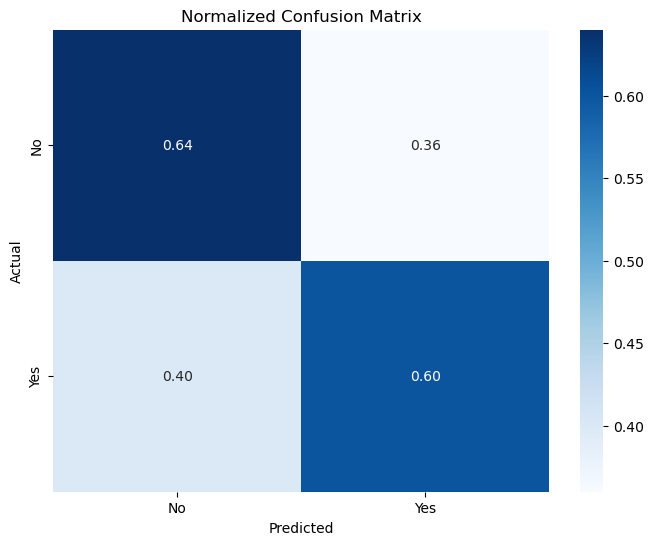

In [65]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Print normalized confusion matrix
print("Normalized Confusion Matrix:")
print(cm_normalized)

# Optionally, you can print additional classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.savefig('Confusion Matrix')
plt.show()

